# GeoText - Sub Regions (Demonyms and SubContinent Datasets)

In [4]:
!pip install geotext

!pip install chardet

import chardet

with open('continents-map.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(result)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 4.5 MB/s eta 0:00:00
{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


Number of entries with identified sub-regions: 7316
                                                   title          sub_region
6618   French Father Comforts Son During Live Intervi...      Western Europe
68120  German citizen praising the führer (1942 color...      Western Europe
56763           The Syrian War Is Over, and America Lost        Western Asia
82154  Taiwan parliament becomes first in Asia to leg...        Eastern Asia
31787  Rare photo detailing Vietnamese guerilla tacti...  South-eastern Asia
8892   Swedish Conservative Party (Allmänna valmansfö...     Northern Europe
14939  "What Buddhist scriptures? Absolutely dogshit....        Eastern Asia
34310  "To learn From The Soviet People Means To Lear...      Western Europe
59974  PsBattle: "Young Ibex on the fork of Disteis (...     Southern Europe
2185   Sweden introduces 6-hour work day to keep work...     Northern Europe

=== Analysis for Sub-Region: Eastern Europe ===


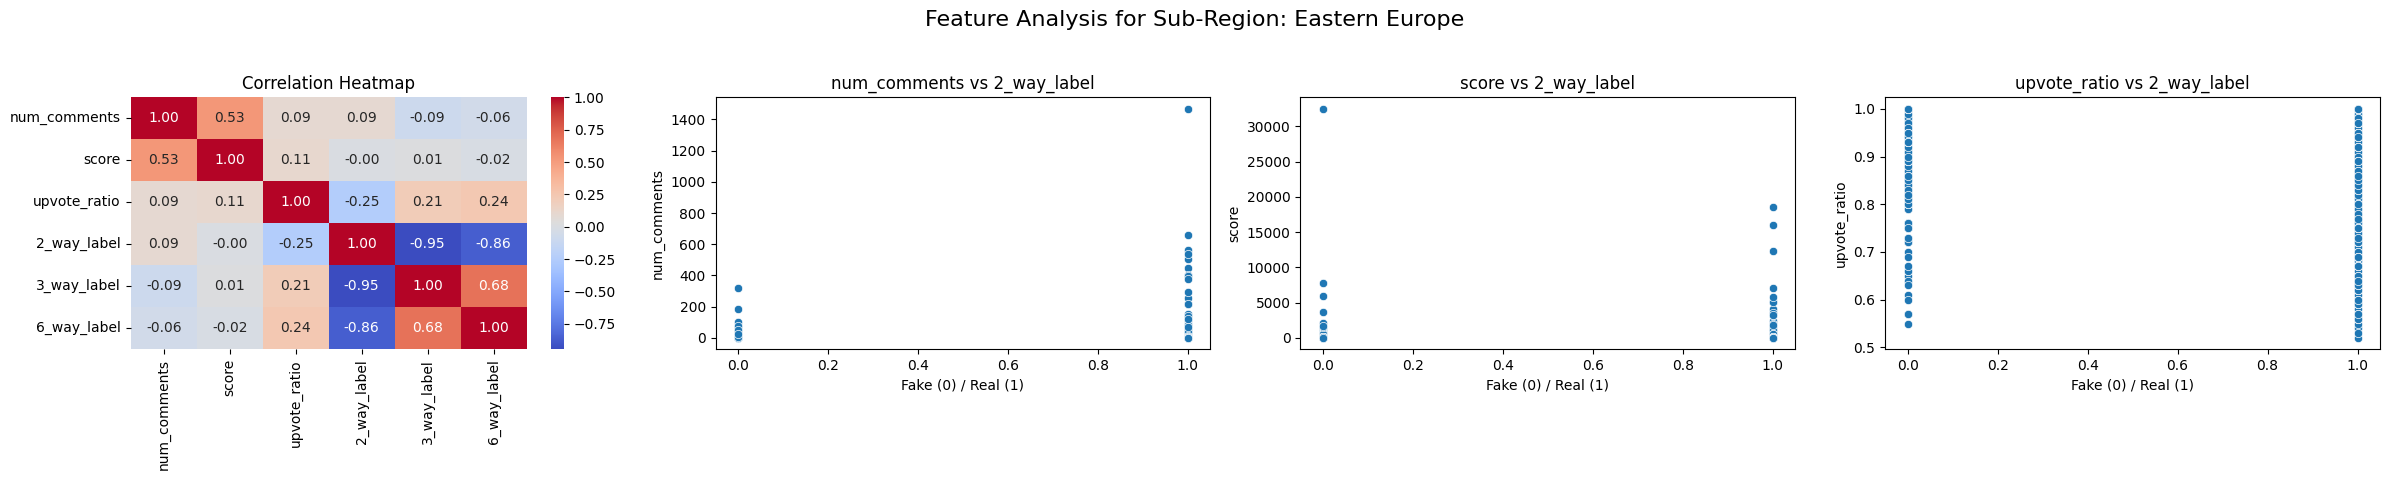


=== Analysis for Sub-Region: Eastern Asia ===


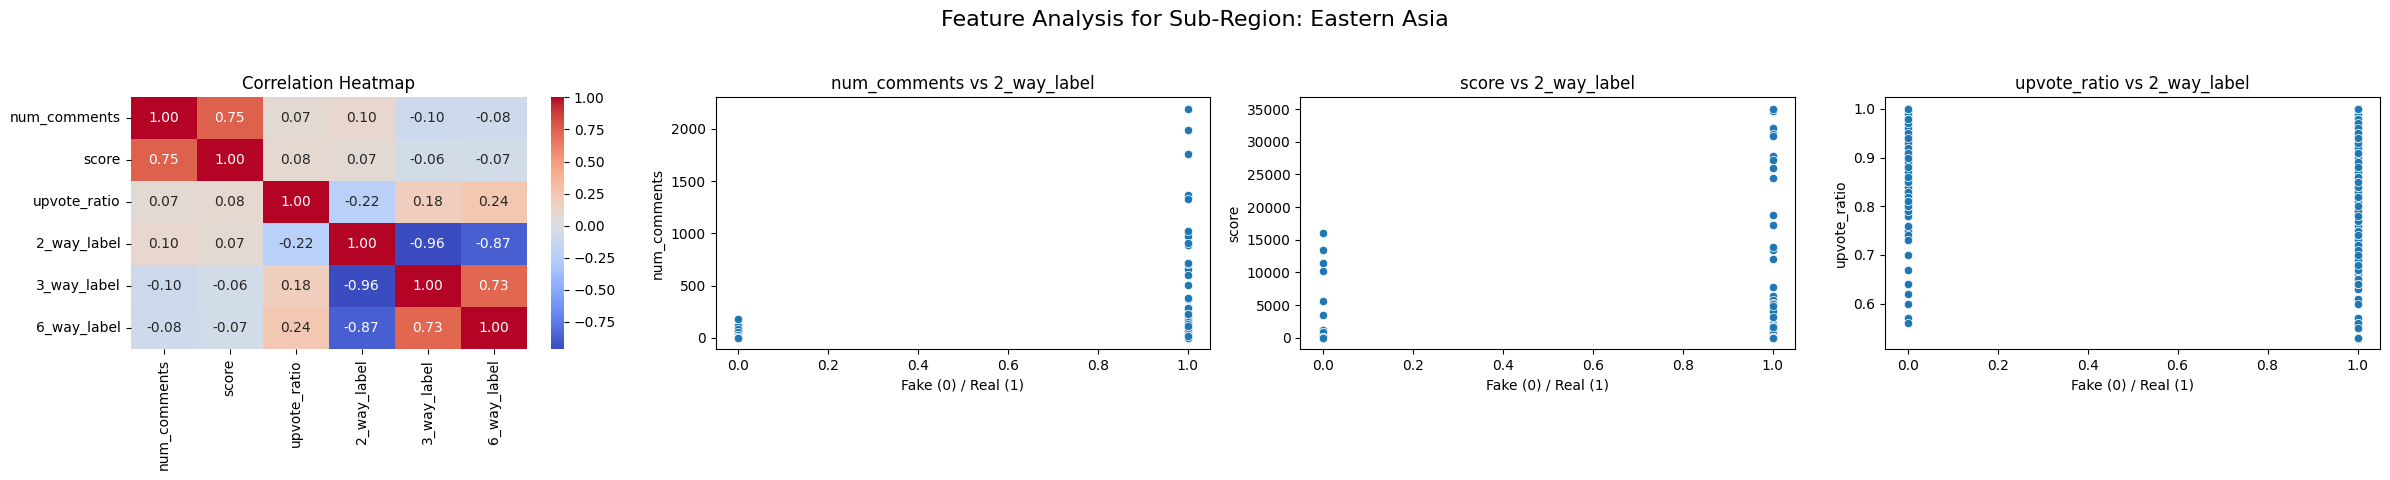


=== Analysis for Sub-Region: Latin America and the Caribbean ===


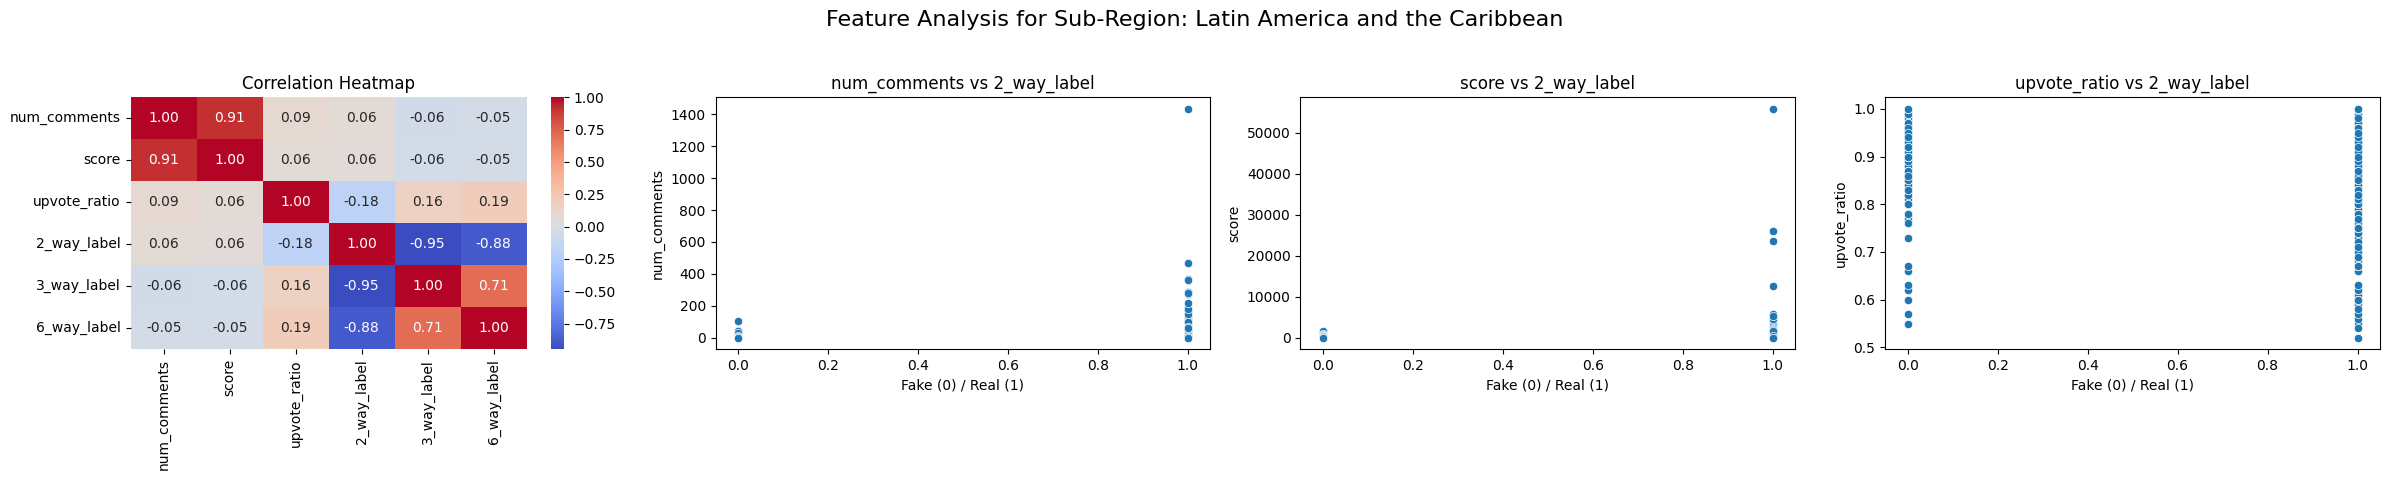


=== Analysis for Sub-Region: Western Europe ===


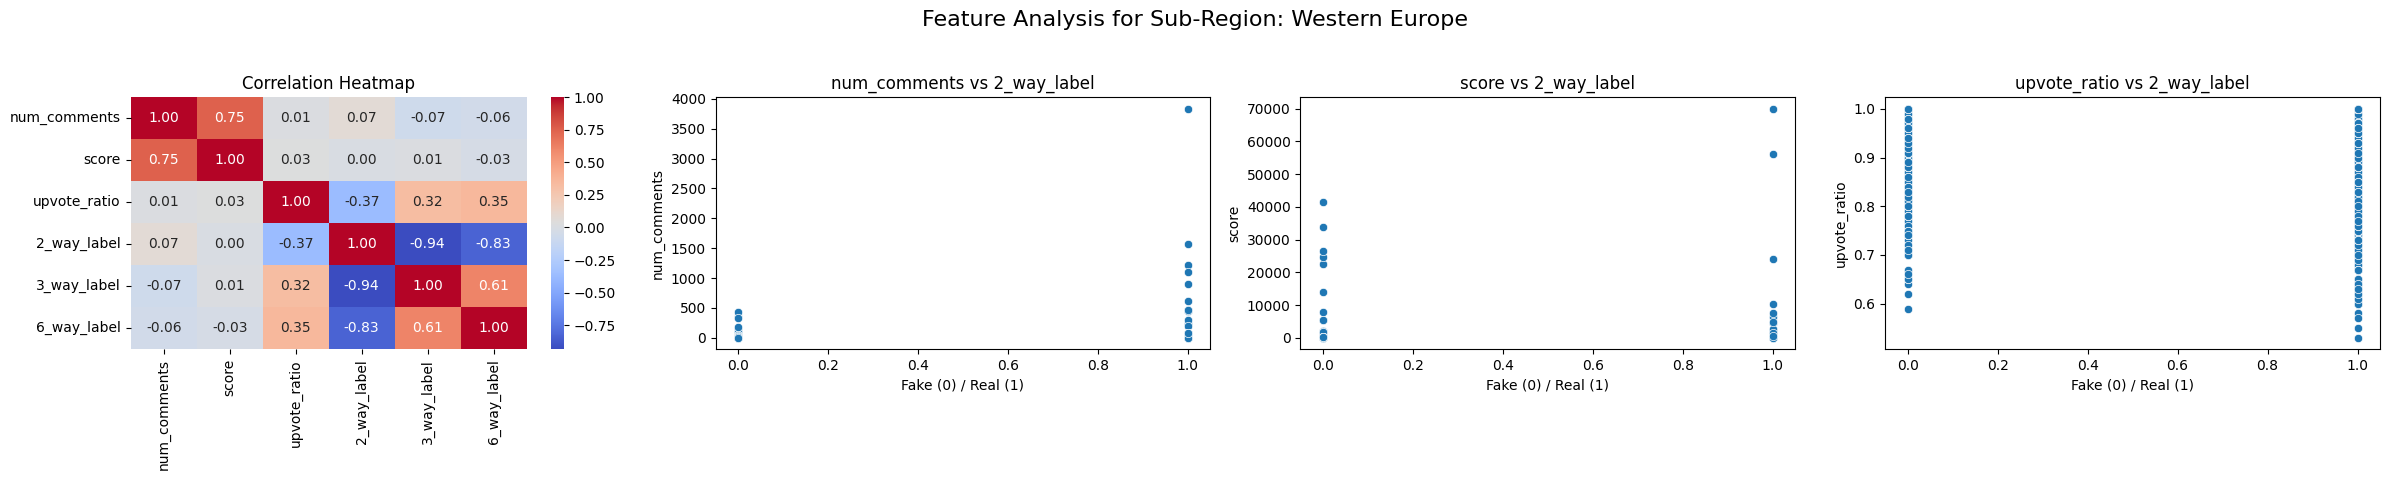


=== Analysis for Sub-Region: Northern Europe ===


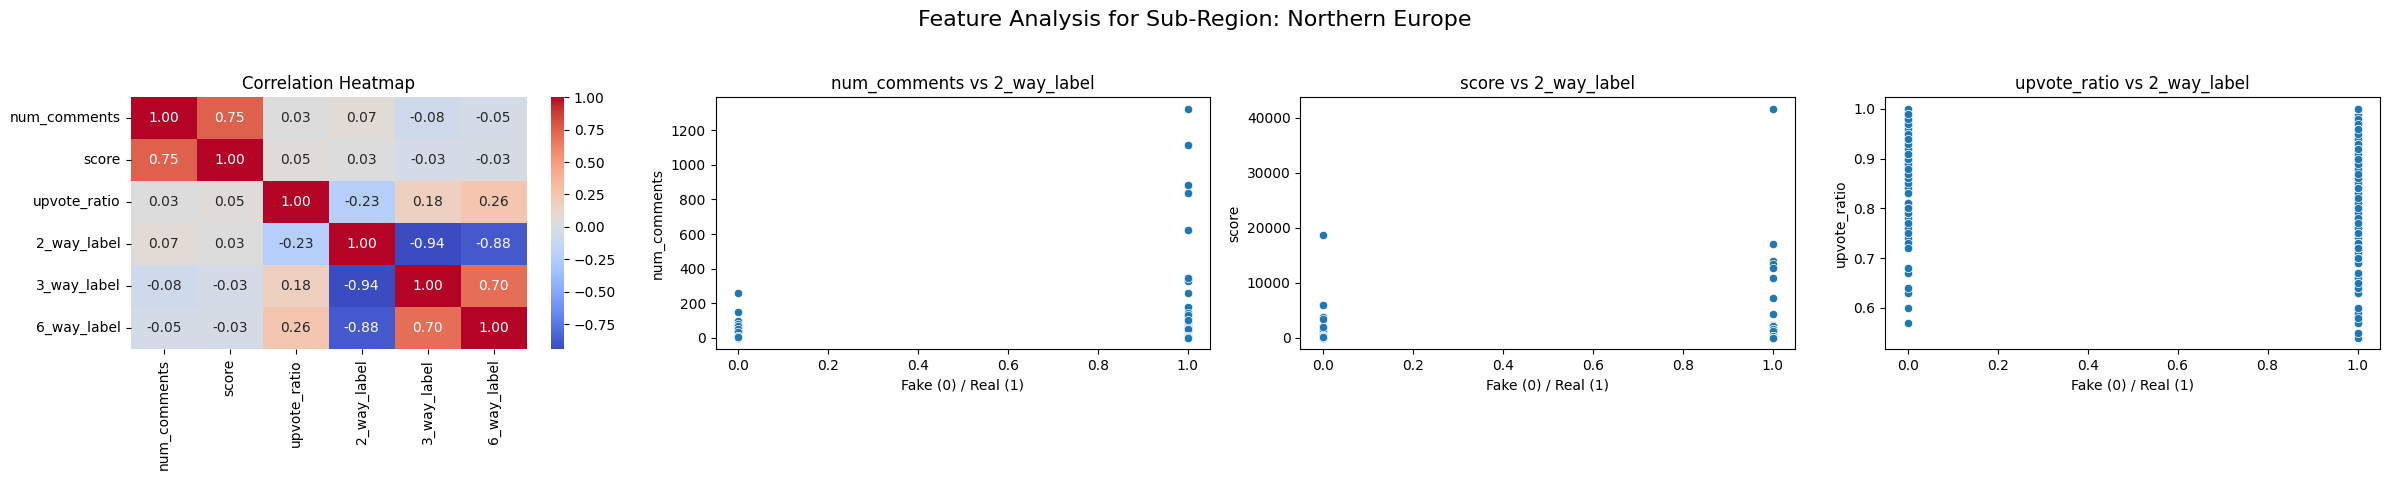


=== Analysis for Sub-Region: Southern Asia ===


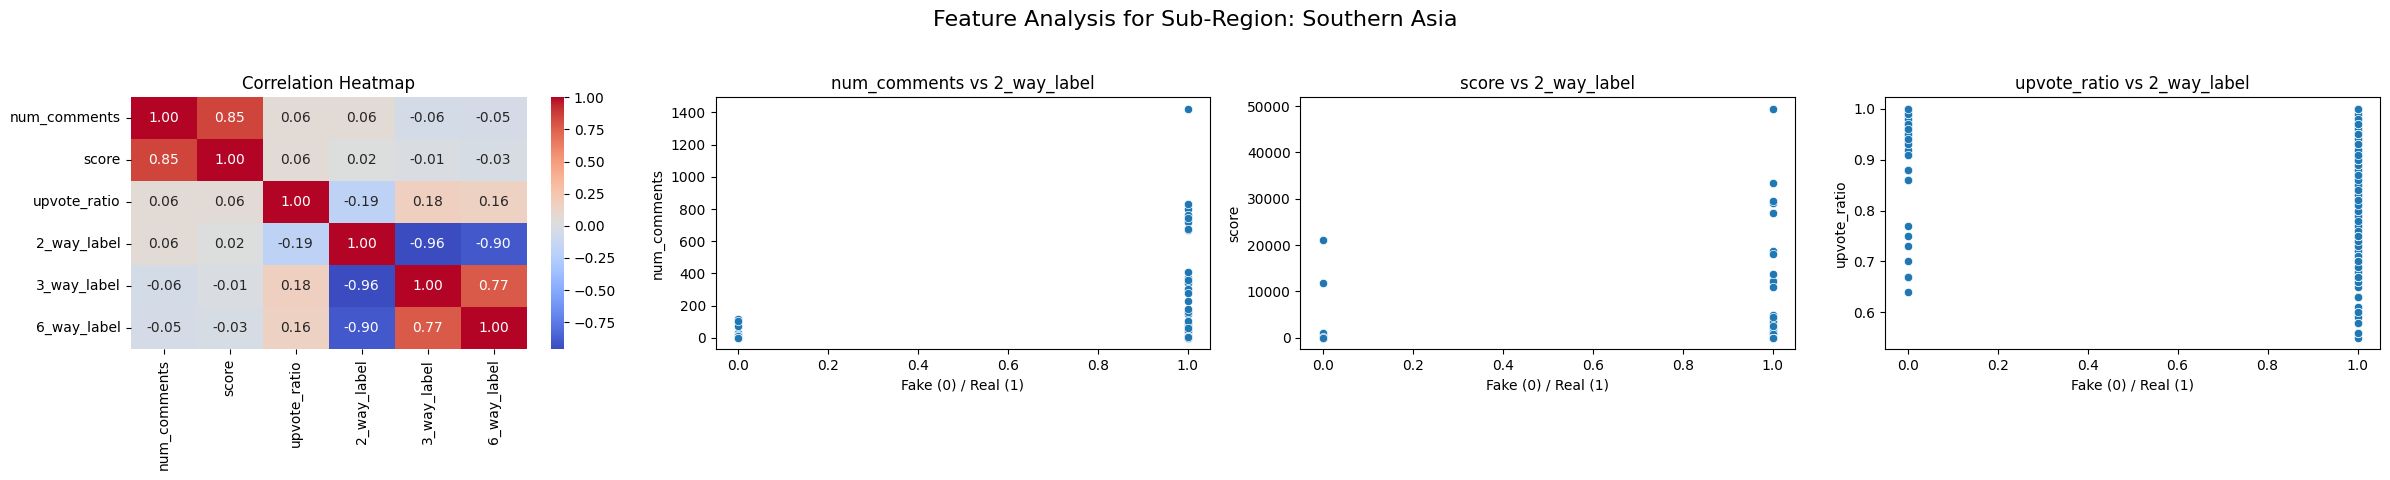


=== Analysis for Sub-Region: Northern America ===


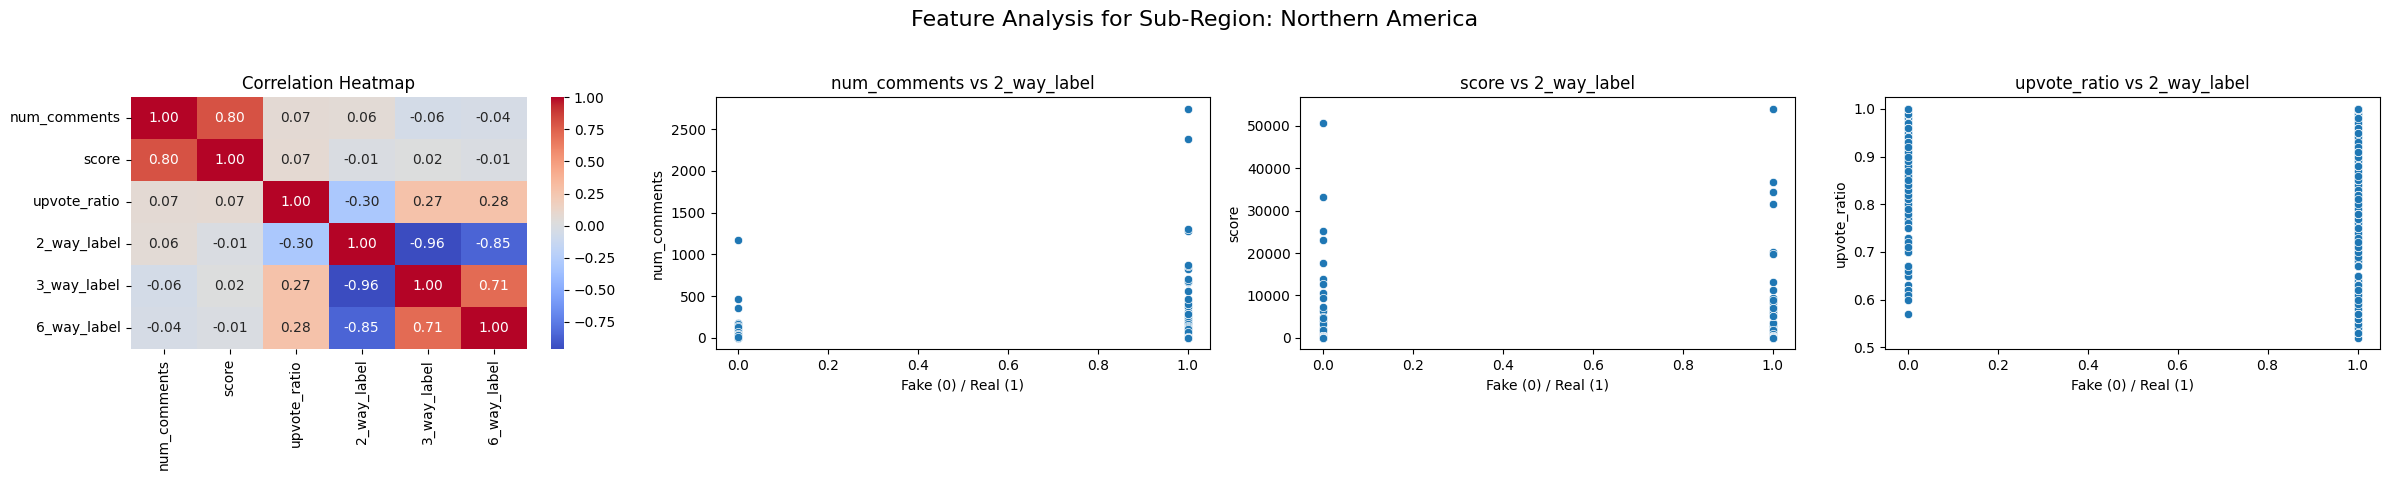


=== Analysis for Sub-Region: South-eastern Asia ===


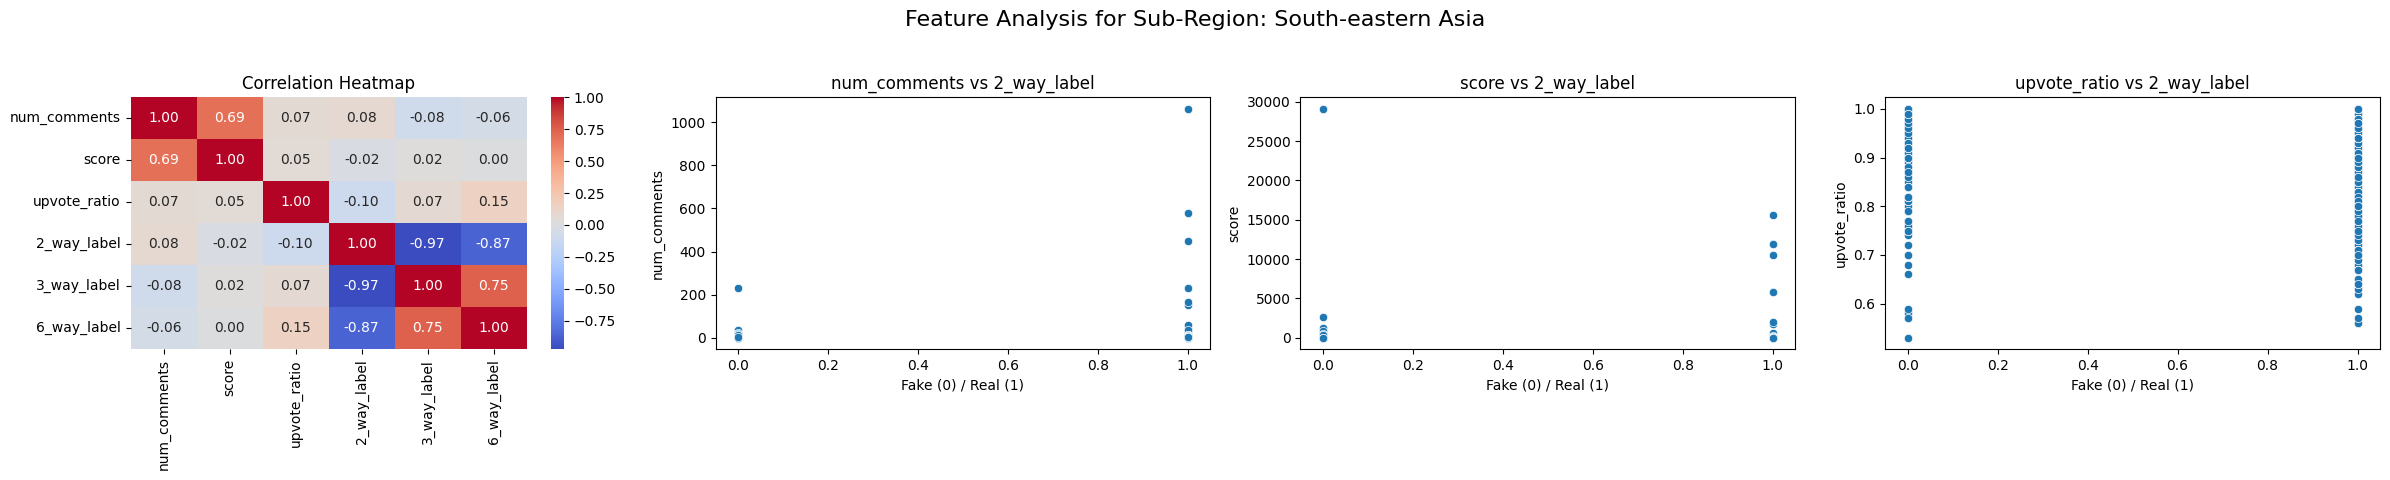


=== Analysis for Sub-Region: Australia and New Zealand ===


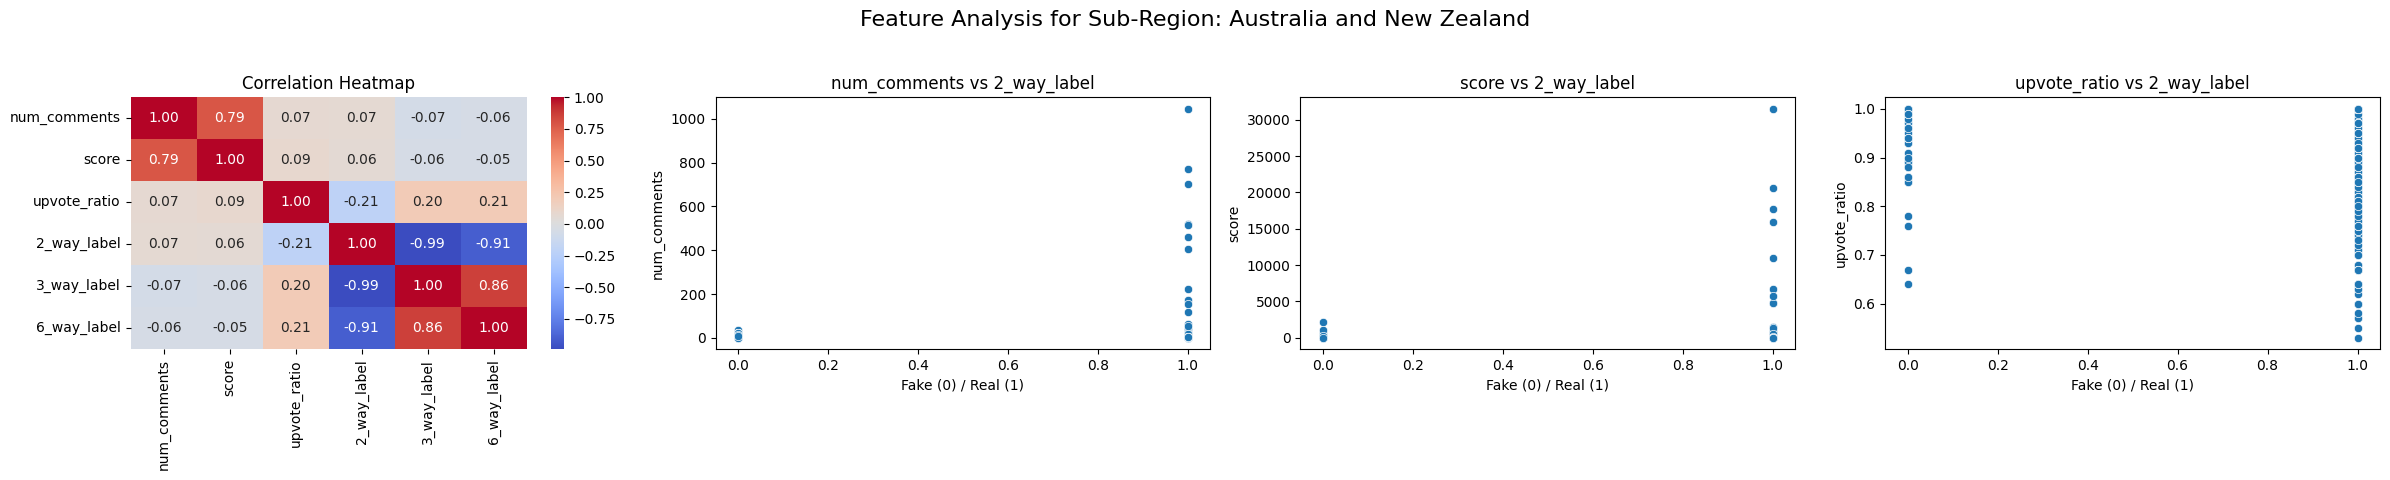


=== Analysis for Sub-Region: Western Asia ===


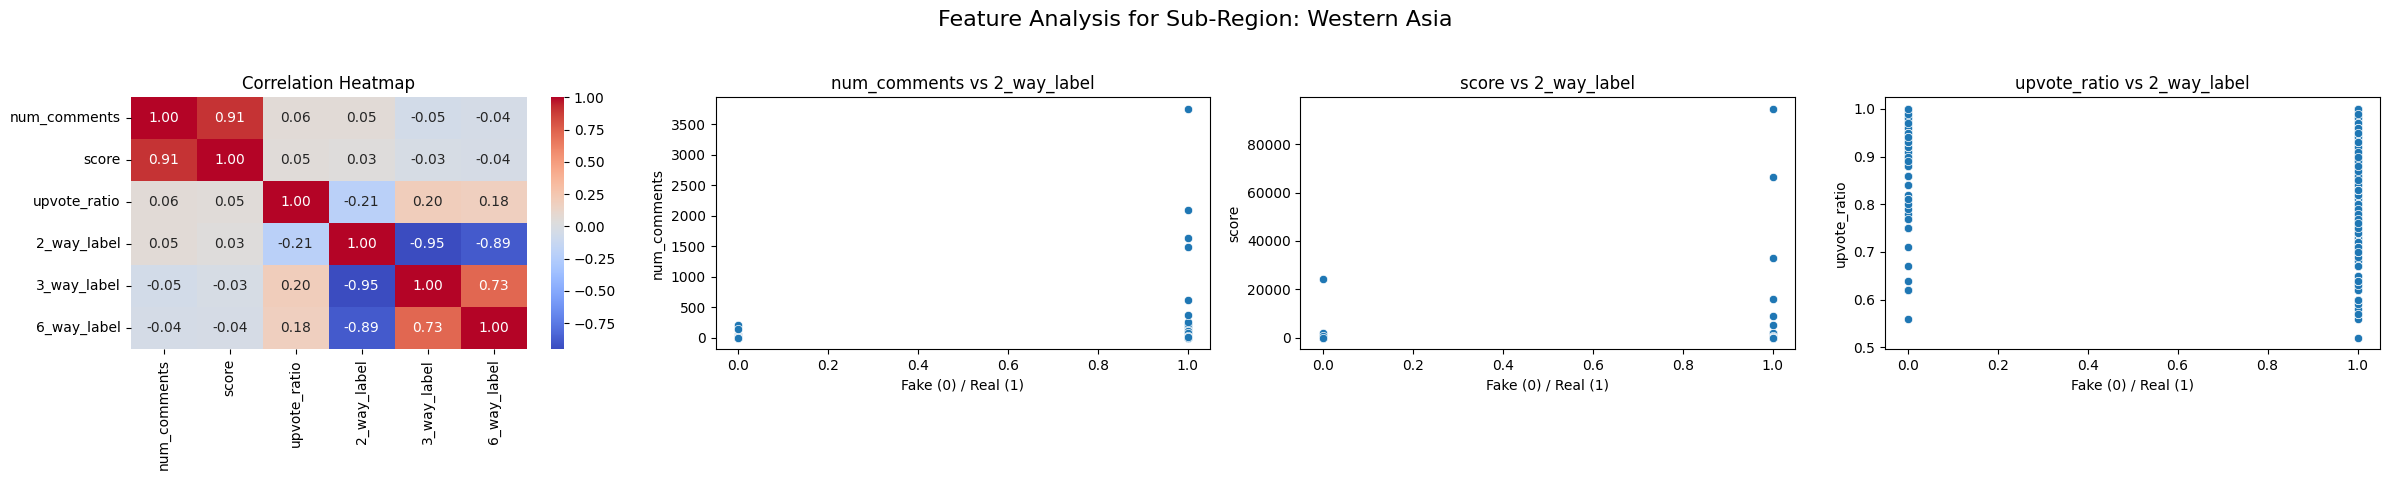


=== Analysis for Sub-Region: Sub-Saharan Africa ===


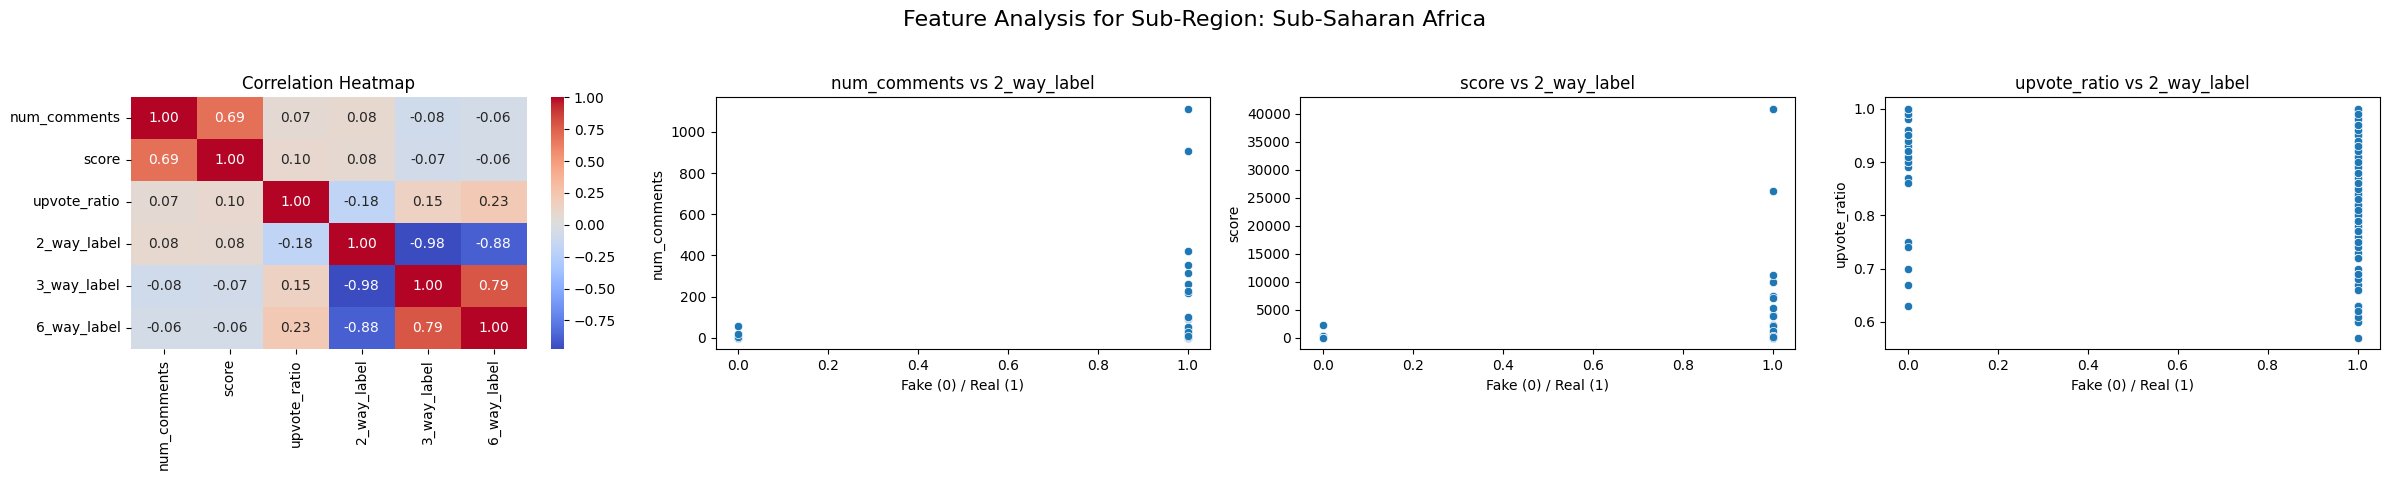


=== Analysis for Sub-Region: Northern Africa ===


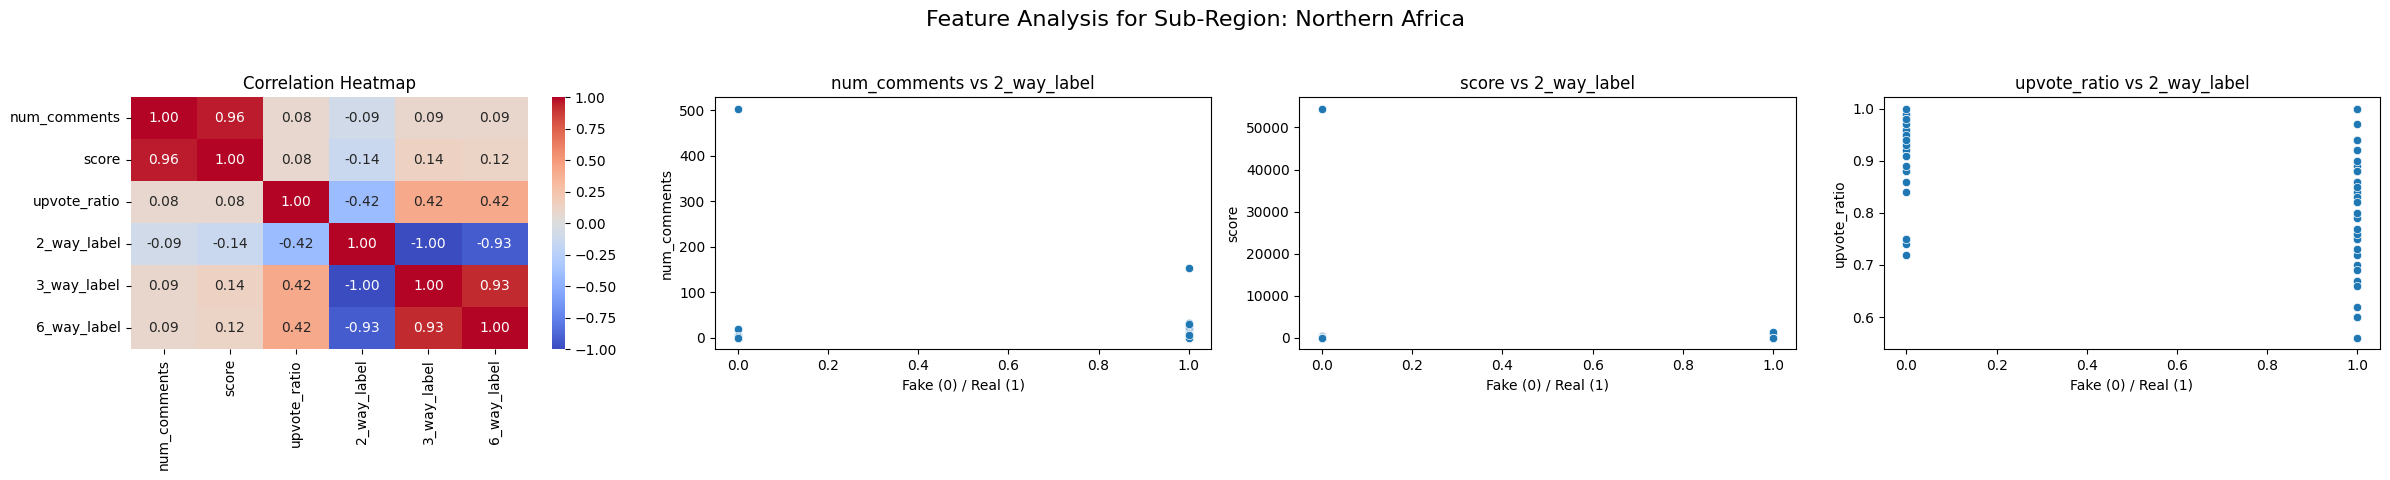


=== Analysis for Sub-Region: Southern Europe ===


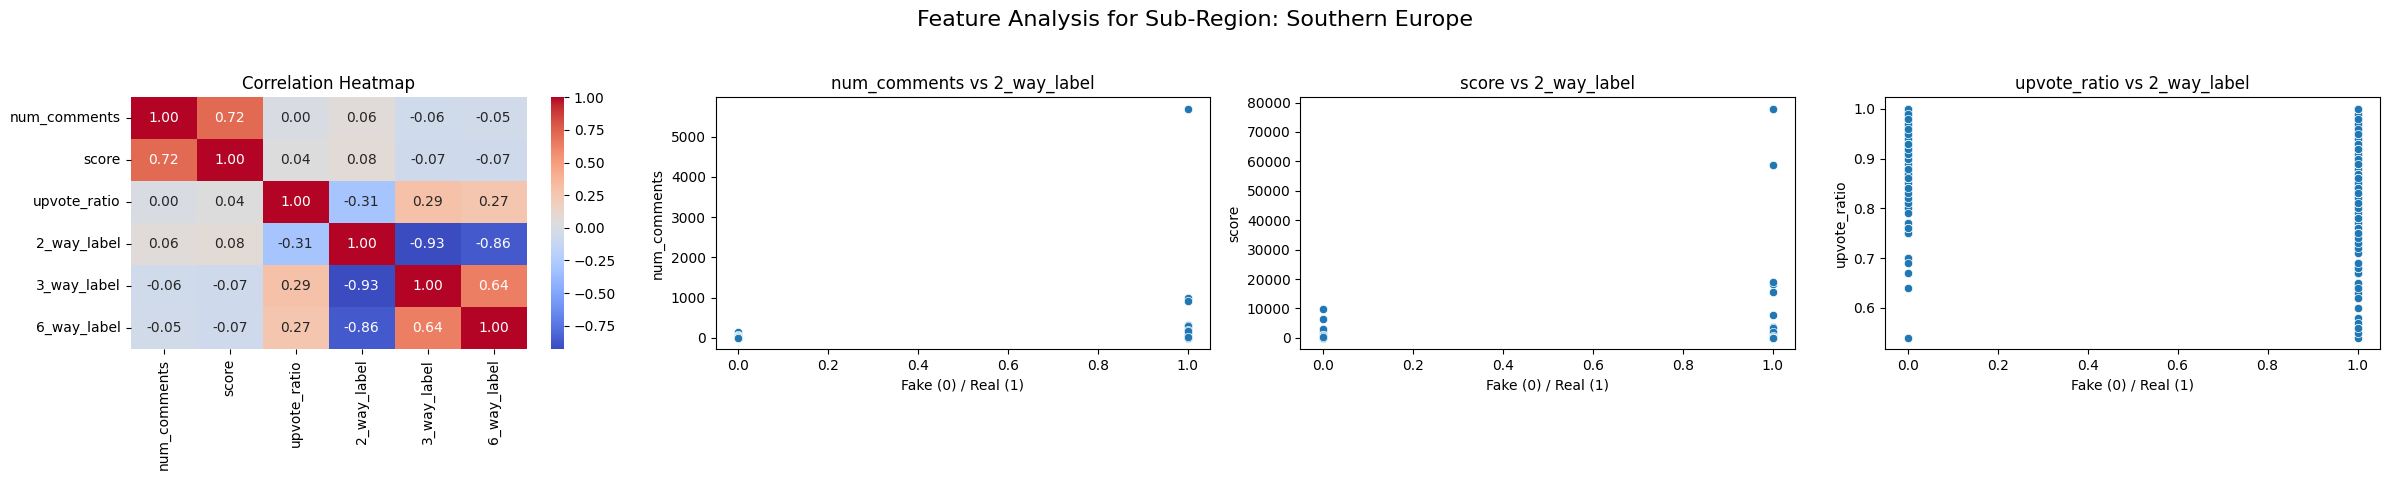


=== Analysis for Sub-Region: Antarctica ===


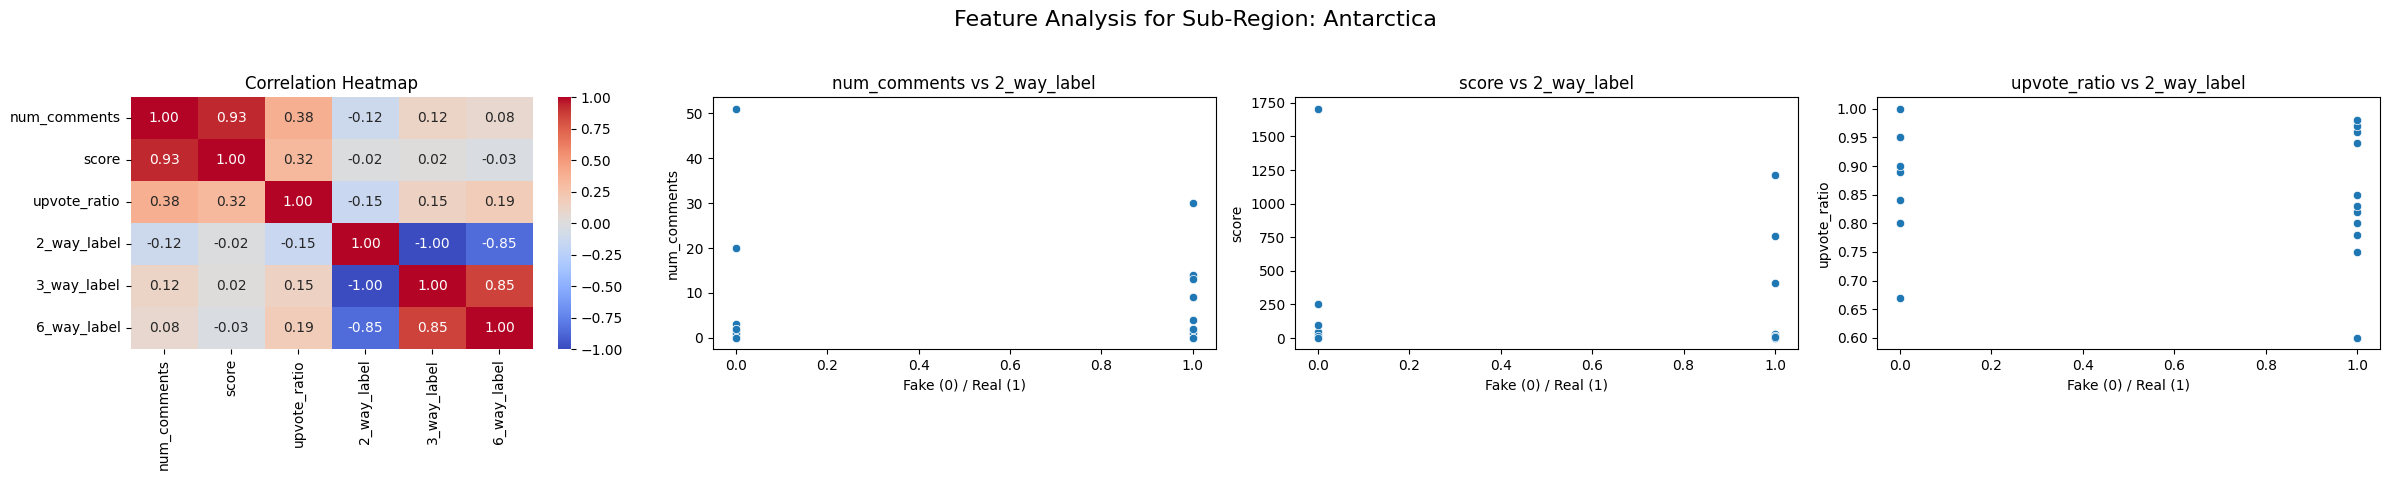


=== Analysis for Sub-Region: Central Asia ===


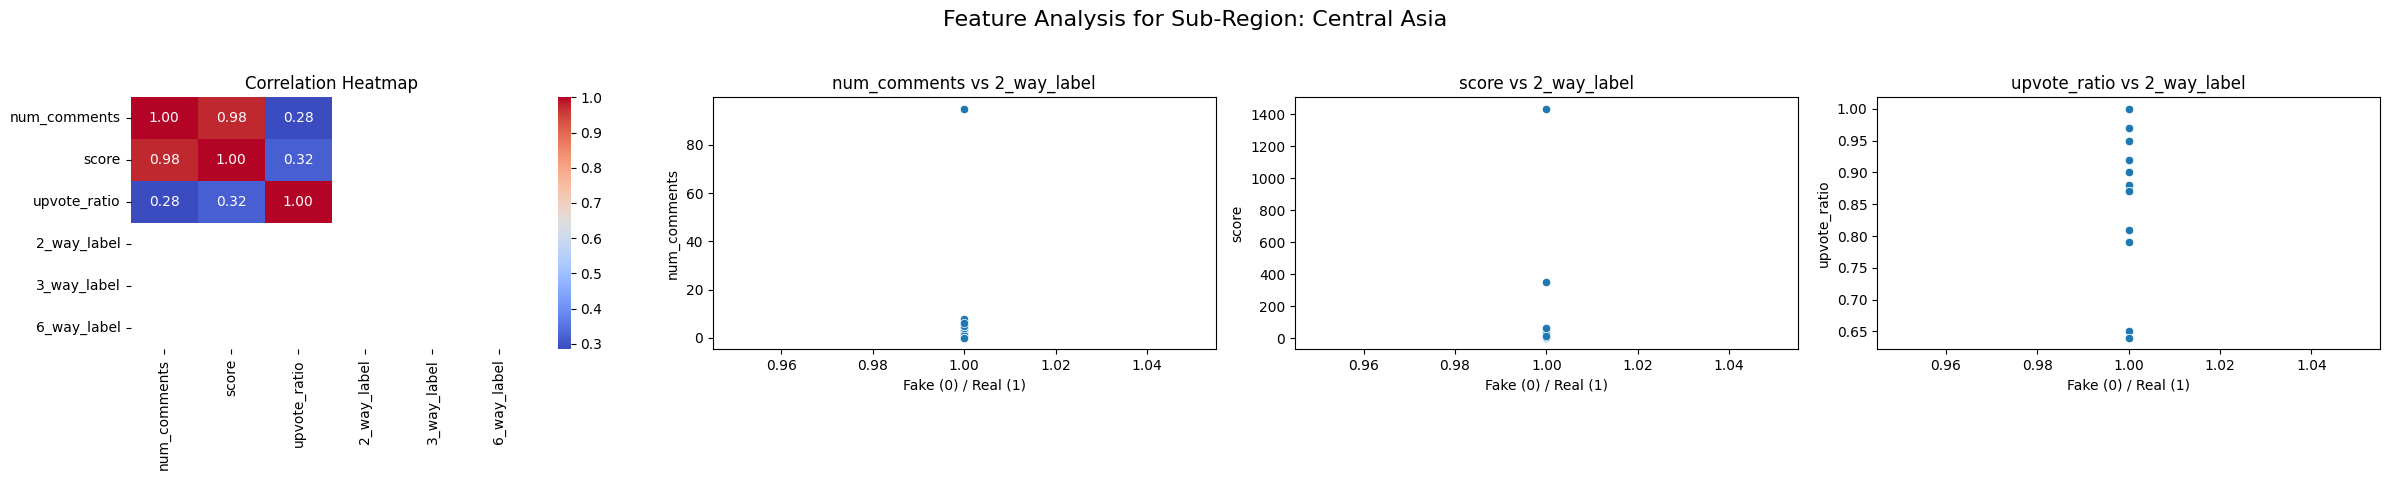

In [5]:
import pandas as pd
from geotext import GeoText
import seaborn as sns
import matplotlib.pyplot as plt

# Load main dataset
df = pd.read_csv('all_validate.csv')

# Load demonyms dataset
demonyms_df = pd.read_csv('demonyms.csv', header=None, names=['demonym', 'country'])
demonym_map = dict(zip(demonyms_df['demonym'].str.lower(), demonyms_df['country']))

# Load continents-map dataset
continent_df = pd.read_csv('continents-map.csv', encoding='ISO-8859-1')
continent_map = dict(zip(continent_df['name'], continent_df['sub-region']))

# Function to extract location and map to subregion
def get_subregion_from_title(title):
    title = str(title)
    places = GeoText(title)

    for place in places.cities + places.countries:
        country = demonym_map.get(place.lower())
        if not country:
            country = place
        subregion = continent_map.get(country)
        if subregion:
            return subregion

    for word in title.lower().split():
        country = demonym_map.get(word)
        if country:
            subregion = continent_map.get(country)
            if subregion:
                return subregion

    return None

# Apply function
df['sub_region'] = df['title'].apply(get_subregion_from_title)

# Save to new CSV
df.to_csv('all_validate_with_subregion.csv', index=False)

# Print number of rows with sub-region
valid_subregion_df = df[df['sub_region'].notna() & (df['sub_region'] != '')]
print(f"Number of entries with identified sub-regions: {len(valid_subregion_df)}")

# Print 10 random samples
print(valid_subregion_df.sample(10)[['title', 'sub_region']])

# Continue with analysis using only valid entries
df = valid_subregion_df.copy()

# Features to analyse
features = ['num_comments', 'score', 'upvote_ratio', '2_way_label', '3_way_label', '6_way_label']
scatter_features = ['num_comments', 'score', 'upvote_ratio']
subregions = df['sub_region'].unique()

# Generate plots per subregion
for region in subregions:
    df_region = df[df['sub_region'] == region]

    if len(df_region) < 10:
        continue  # Skip small sets

    print(f"\n=== Analysis for Sub-Region: {region} ===")

    fig, axes = plt.subplots(1, 4, figsize=(24, 5))
    corr = df_region[features].corr(numeric_only=True)
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
    axes[0].set_title('Correlation Heatmap')

    for i, feature in enumerate(scatter_features):
        sns.scatterplot(data=df_region, x='2_way_label', y=feature, ax=axes[i + 1])
        axes[i + 1].set_title(f'{feature} vs 2_way_label')
        axes[i + 1].set_xlabel('Fake (0) / Real (1)')
        axes[i + 1].set_ylabel(feature)

    fig.suptitle(f'Feature Analysis for Sub-Region: {region}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 1. Group-wise Distribution Plots (Bar/Count)

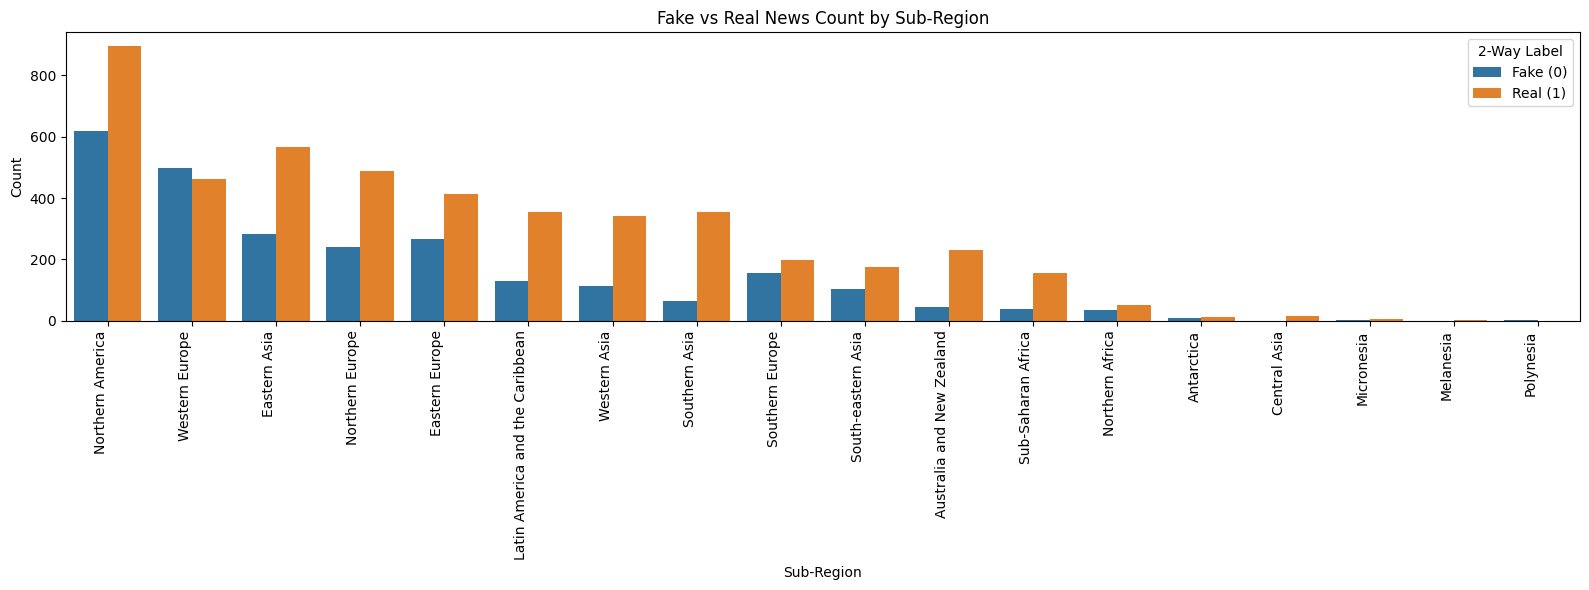

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get sorted subregions to fix order
subregion_order = df['sub_region'].value_counts().index

# Count of fake/real per sub-region
plt.figure(figsize=(16, 6))  # wider than 12
sns.countplot(data=df, x='sub_region', hue='2_way_label', order=subregion_order)
plt.xticks(rotation=90, ha='right')  # 'ha' aligns labels properly
plt.title("Fake vs Real News Count by Sub-Region")
plt.xlabel("Sub-Region")
plt.ylabel("Count")
plt.legend(title='2-Way Label', labels=['Fake (0)', 'Real (1)'])
plt.tight_layout()
plt.show()

## 2. Chi-Square Test of Independence

Chi-square test result:
Chi2 = 346.88, p-value = 0.0000, degrees of freedom = 17
→ Significant association between sub-region and news label.


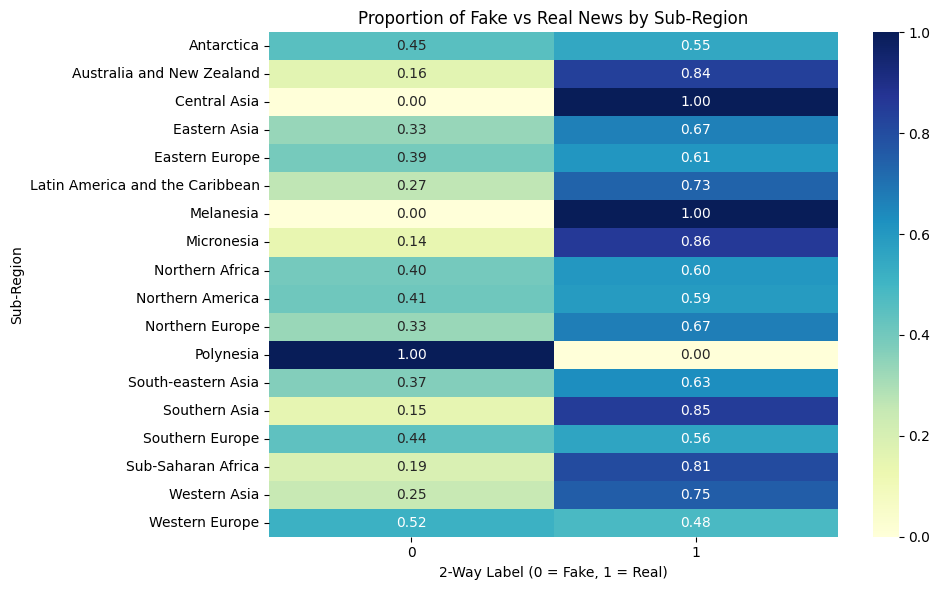

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the contingency table
contingency_table = pd.crosstab(df['sub_region'], df['2_way_label'])

# Chi-square test
chi2, p, dof, ex = chi2_contingency(contingency_table)

# Print results
print("Chi-square test result:")
print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}, degrees of freedom = {dof}")
if p < 0.05:
    print("→ Significant association between sub-region and news label.")
else:
    print("→ No significant association found.")

# Plot heatmap
prop_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(prop_table, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Proportion of Fake vs Real News by Sub-Region')
plt.xlabel('2-Way Label (0 = Fake, 1 = Real)')
plt.ylabel('Sub-Region')
plt.tight_layout()
plt.show()

## 3. Boxplots for Feature Distributions by Sub-Region

<ipython-input-22-9eaae2be02c9>:8: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=df_filtered, x='sub_region', y='score', hue='2_way_label',


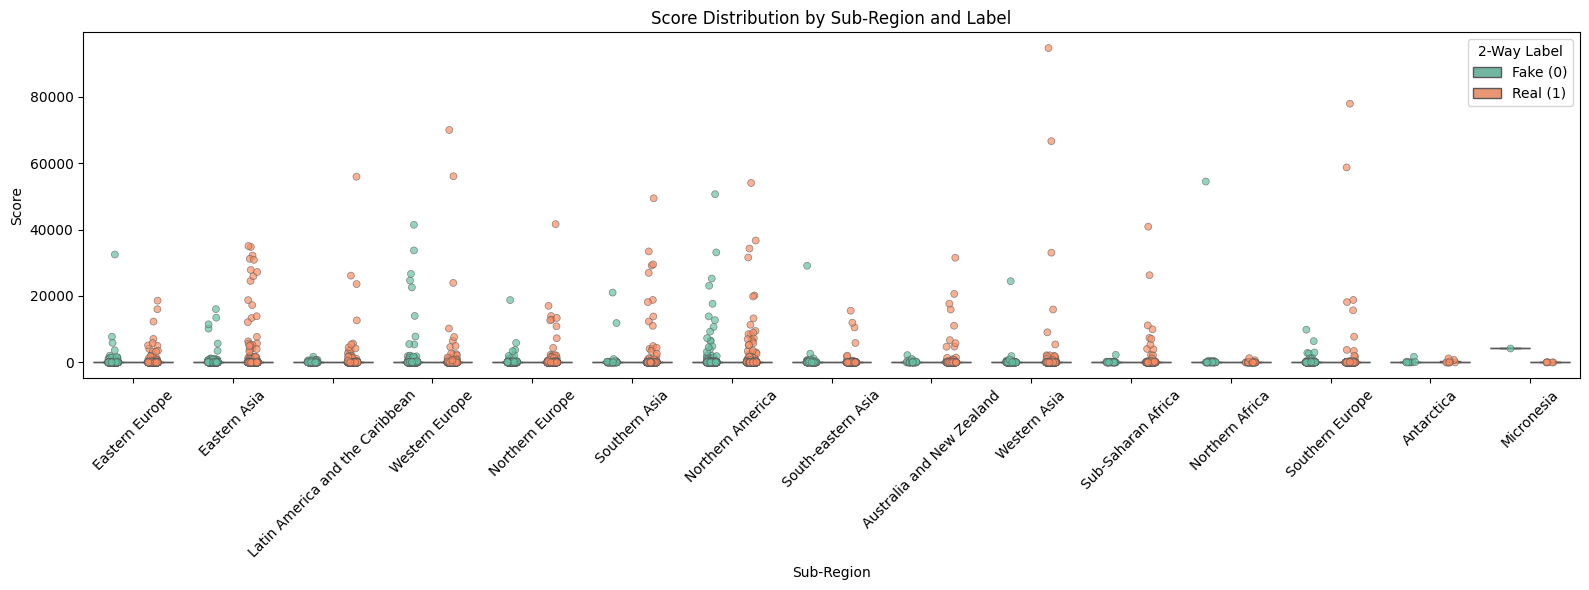

In [22]:
plt.figure(figsize=(16, 6))

# Draw boxplot without showing outliers (set flierprops marker size to 0)
sns.boxplot(data=df_filtered, x='sub_region', y='score', hue='2_way_label',
            palette='Set2', showfliers=False)

# Overlay the points (dots) with hue colouring
sns.stripplot(data=df_filtered, x='sub_region', y='score', hue='2_way_label',
              palette='Set2', dodge=True, jitter=True, alpha=0.7, marker='o', edgecolor='gray', linewidth=0.5)

plt.title('Score Distribution by Sub-Region and Label')
plt.xlabel('Sub-Region')
plt.ylabel('Score')
plt.xticks(rotation=45)

# Remove duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], ['Fake (0)', 'Real (1)'], title='2-Way Label')

plt.tight_layout()
plt.show()

## 4. Train Classifiers Separately for Each Sub-Region

Split the dataset by sub-region and train classifiers (e.g., Logistic Regression, Random Forest) to compare performance.

This helps see if detection accuracy varies by sub-region, which might suggest that sub-region-specific patterns exist.

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Store metrics
all_metrics = []

for region in subregions:
    df_region = df[df['sub_region'] == region]
    if len(df_region) < 50:
        continue

    X = df_region[['num_comments', 'score', 'upvote_ratio']]
    y = df_region['2_way_label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]  # for ROC AUC

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\nRegion: {region}")
    print(f"  Accuracy : {acc:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall   : {recall:.2f}")
    print(f"  F1 Score : {f1:.2f}")
    print(f"  ROC AUC  : {auc:.2f}")

    all_metrics.append([acc, precision, recall, f1, auc])

# Overall mean of each metric
if all_metrics:
    metrics_df = pd.DataFrame(all_metrics, columns=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'])
    print("\n=== Overall Mean Metrics Across Sub-Regions ===")
    print(metrics_df.mean())
else:
    print("\nNo sub-regions had sufficient data for evaluation.")


Region: Eastern Europe
  Accuracy : 0.66
  Precision: 0.69
  Recall   : 0.76
  F1 Score : 0.72
  ROC AUC  : 0.71

Region: Eastern Asia
  Accuracy : 0.74
  Precision: 0.80
  Recall   : 0.80
  F1 Score : 0.80
  ROC AUC  : 0.80

Region: Latin America and the Caribbean
  Accuracy : 0.70
  Precision: 0.75
  Recall   : 0.85
  F1 Score : 0.80
  ROC AUC  : 0.69

Region: Western Europe
  Accuracy : 0.68
  Precision: 0.67
  Recall   : 0.67
  F1 Score : 0.67
  ROC AUC  : 0.76

Region: Northern Europe
  Accuracy : 0.80
  Precision: 0.85
  Recall   : 0.87
  F1 Score : 0.86
  ROC AUC  : 0.81

Region: Southern Asia
  Accuracy : 0.87
  Precision: 0.92
  Recall   : 0.93
  F1 Score : 0.93
  ROC AUC  : 0.74

Region: Northern America
  Accuracy : 0.72
  Precision: 0.73
  Recall   : 0.85
  F1 Score : 0.78
  ROC AUC  : 0.79

Region: South-eastern Asia
  Accuracy : 0.61
  Precision: 0.69
  Recall   : 0.73
  F1 Score : 0.71
  ROC AUC  : 0.57

Region: Australia and New Zealand
  Accuracy : 0.85
  Precision: 0

## 5. Multivariate Analysis: Logistic Regression with Region

In [33]:
from sklearn.preprocessing import OrdinalEncoder

# Instead of OneHotEncoder, use OrdinalEncoder for cat_cols
preprocessor = ColumnTransformer([
    ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), num_cols),
    ('cat', OrdinalEncoder(), cat_cols)
])

pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=2000))
pipeline.fit(X_train, y_train)

# After training
coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = num_cols + cat_cols  # only one 'sub_region' feature now

print("\nFeature Weights (Logistic Regression Coefficients):")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.3f}")


Feature Weights (Logistic Regression Coefficients):
num_comments: 1.260
score: -0.386
upvote_ratio: -0.638
sub_region: -0.034


# Spacy (Demonyms, continents-map)

In [37]:
!pip install spacy
!python m spacy download en_core_web_sm

python3: can't open file '/content/m': [Errno 2] No such file or directory


Number of entries with identified sub-regions: 7400
                                                   title  \
25508  Christian broadcaster: Ebola could cleanse US ...   
78678                        [1915]Save Serbia, our ally   
90924  Australian sheep farmer faces complaint from P...   
62159  (UK) Government agrees to change law to protec...   
5670   ‘South Park’ banned in China after mocking Chi...   
78206  Frida: the Mexican rescue dog who has saved mo...   
85706   US top cop decries encryption, demands backdoors   
2454   Dead referee 'appointed' to officiate Nigerian...   
33998  Historic meeting of United States Mafia and Co...   
44550  An Asian American woman duals with a Bedouin c...   

                            sub_region  
25508                 Northern America  
78678                  Southern Europe  
90924        Australia and New Zealand  
62159                  Northern Europe  
5670                      Eastern Asia  
78206  Latin America and the Caribbean  


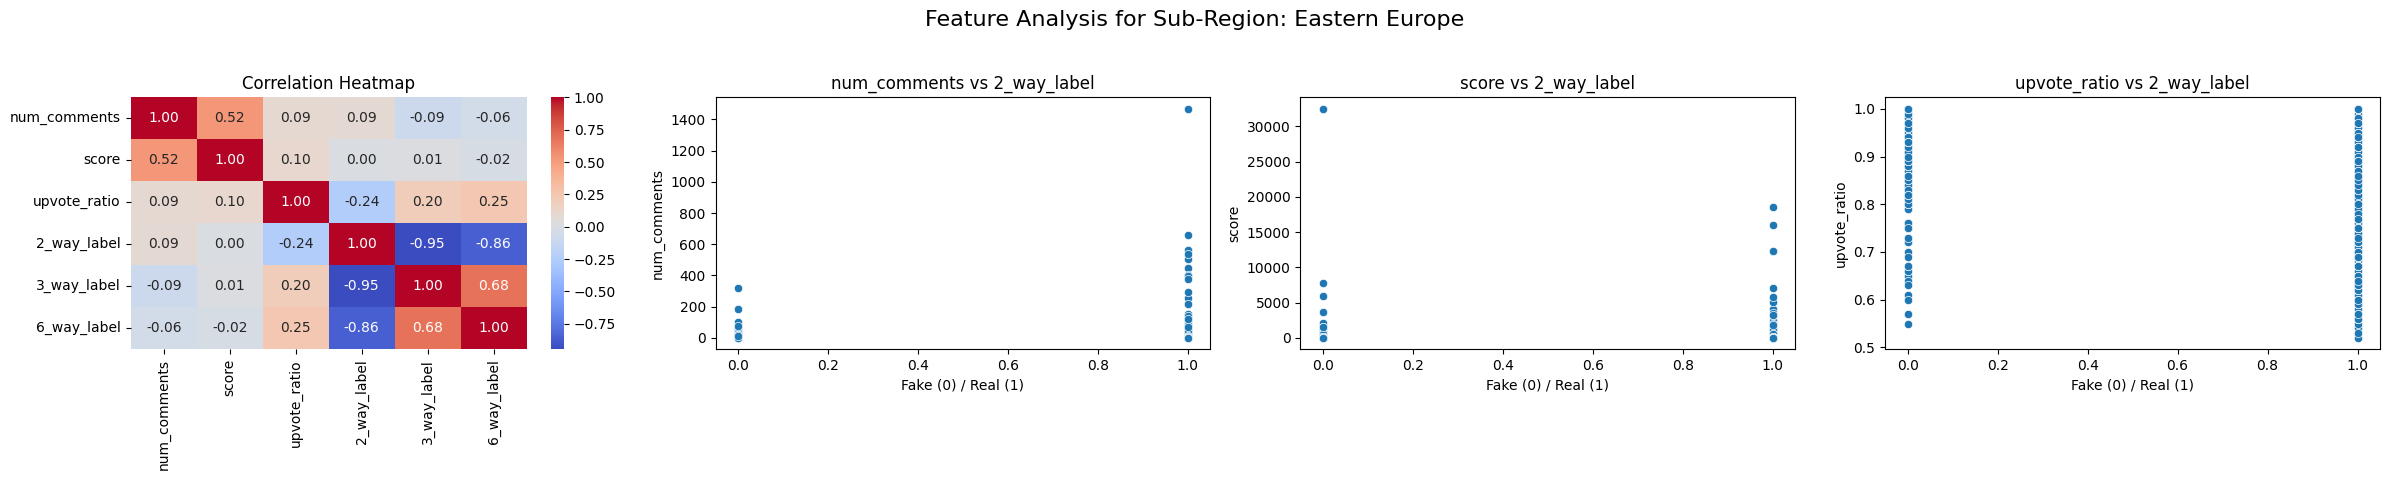


=== Analysis for Sub-Region: Eastern Asia ===


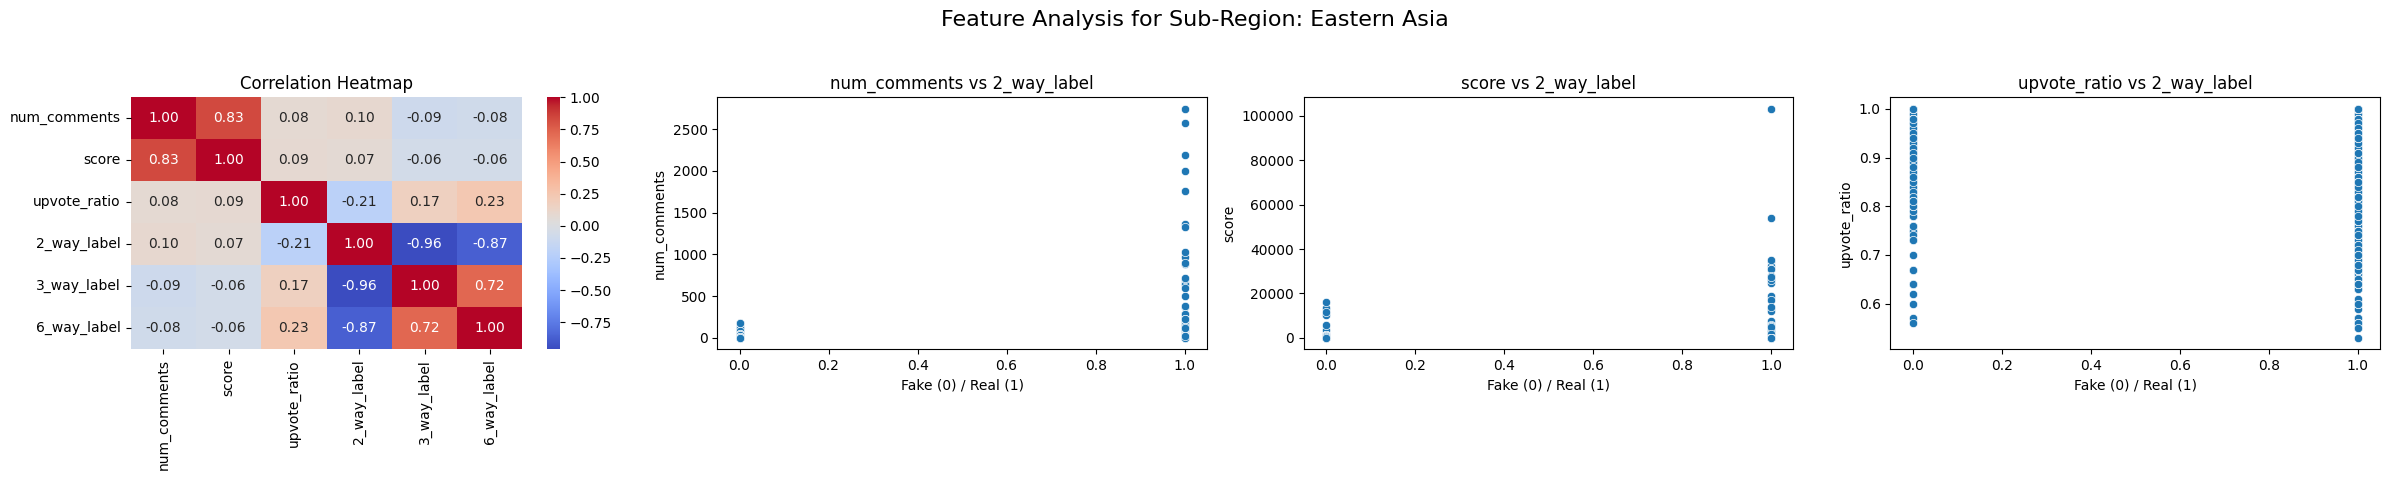


=== Analysis for Sub-Region: Western Europe ===


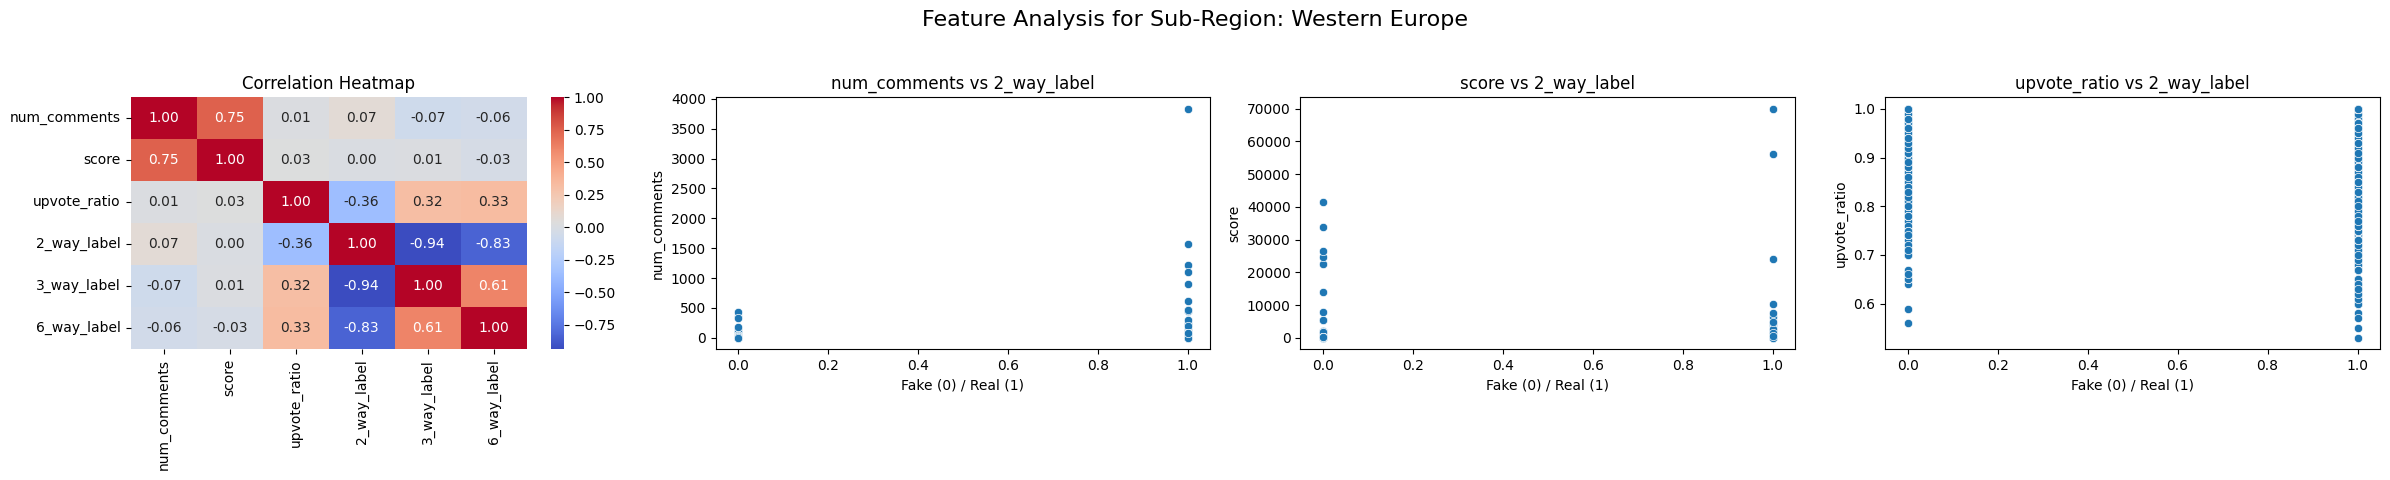


=== Analysis for Sub-Region: Northern Europe ===


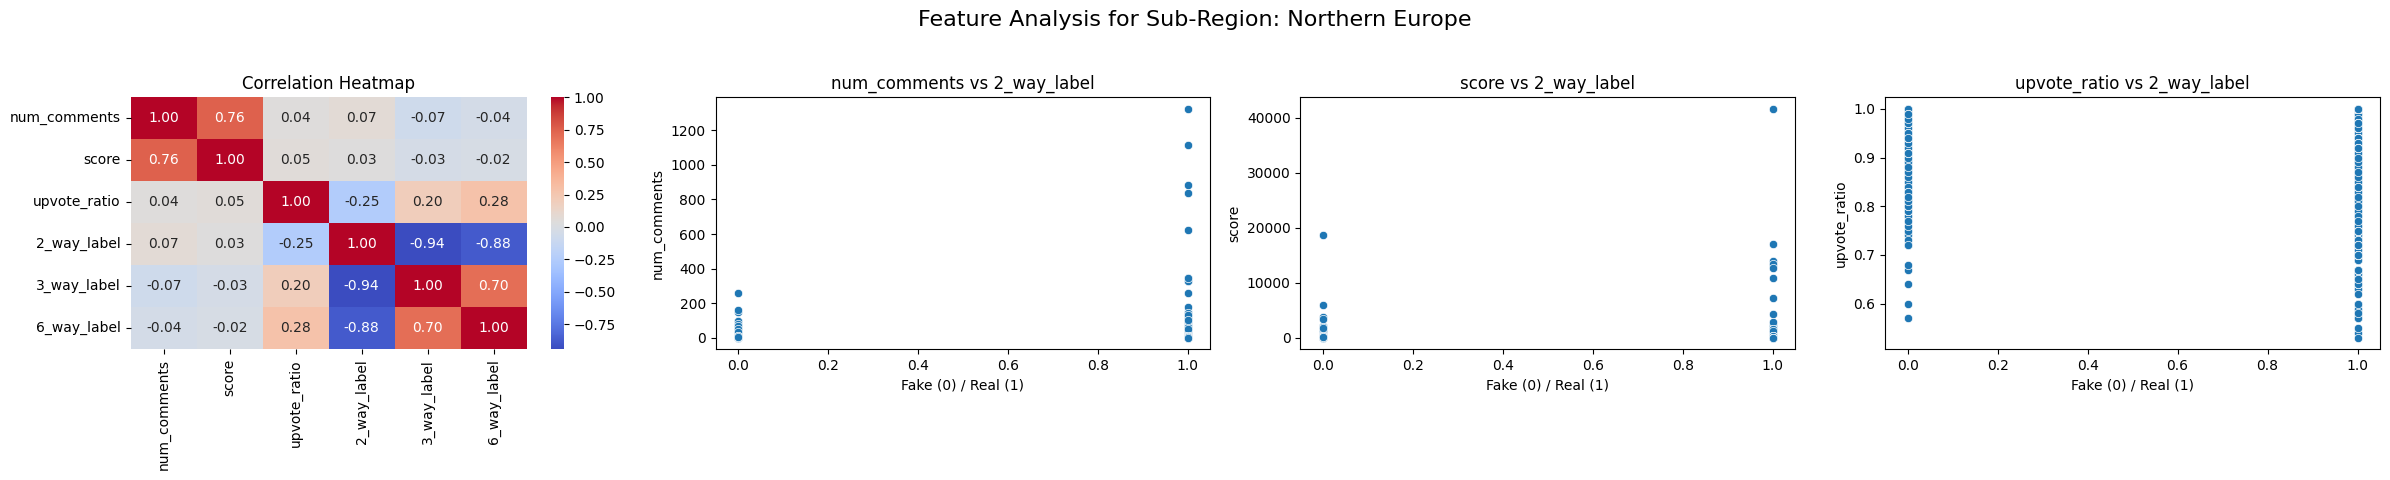


=== Analysis for Sub-Region: Latin America and the Caribbean ===


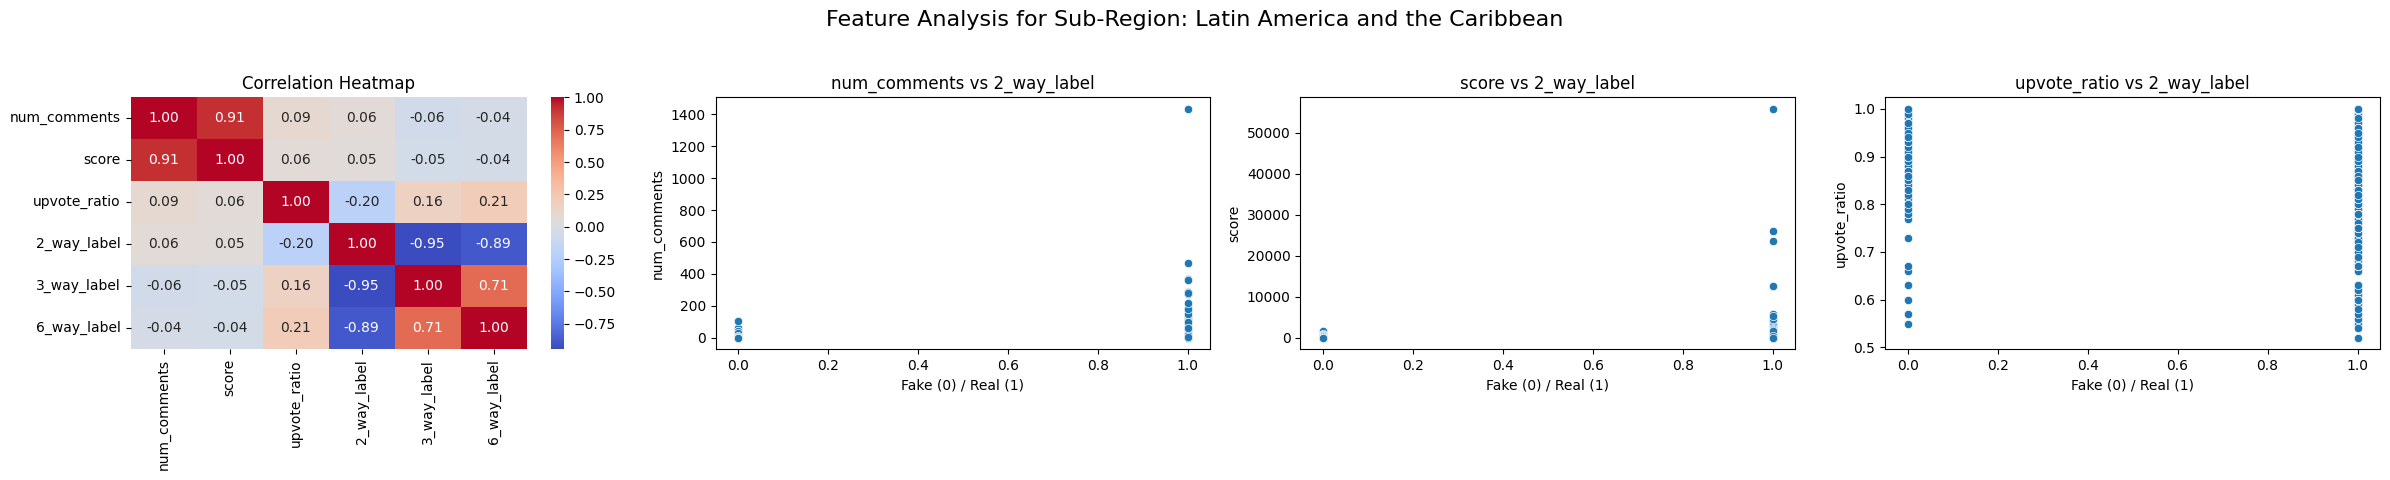


=== Analysis for Sub-Region: Southern Asia ===


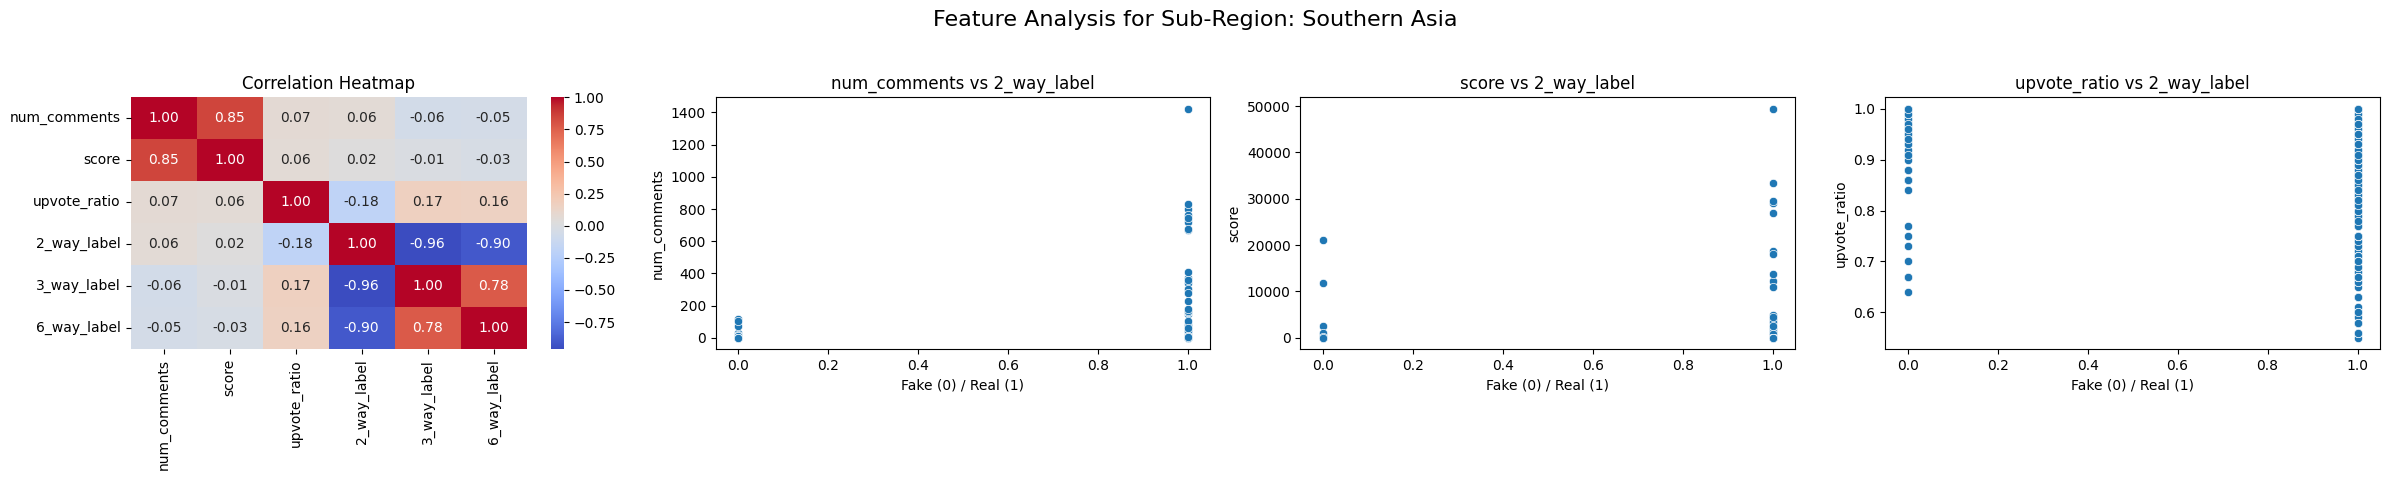


=== Analysis for Sub-Region: Northern America ===


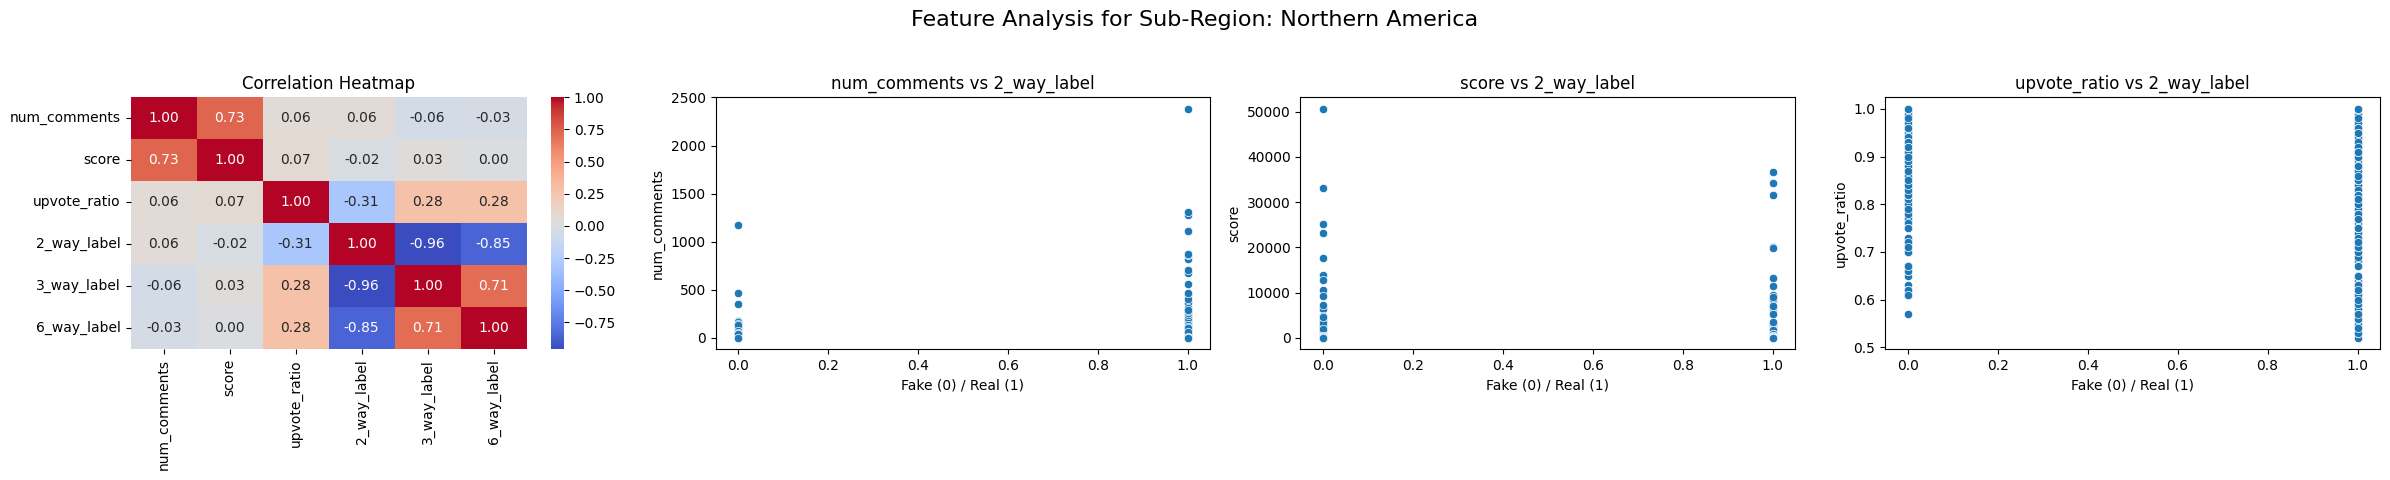


=== Analysis for Sub-Region: South-eastern Asia ===


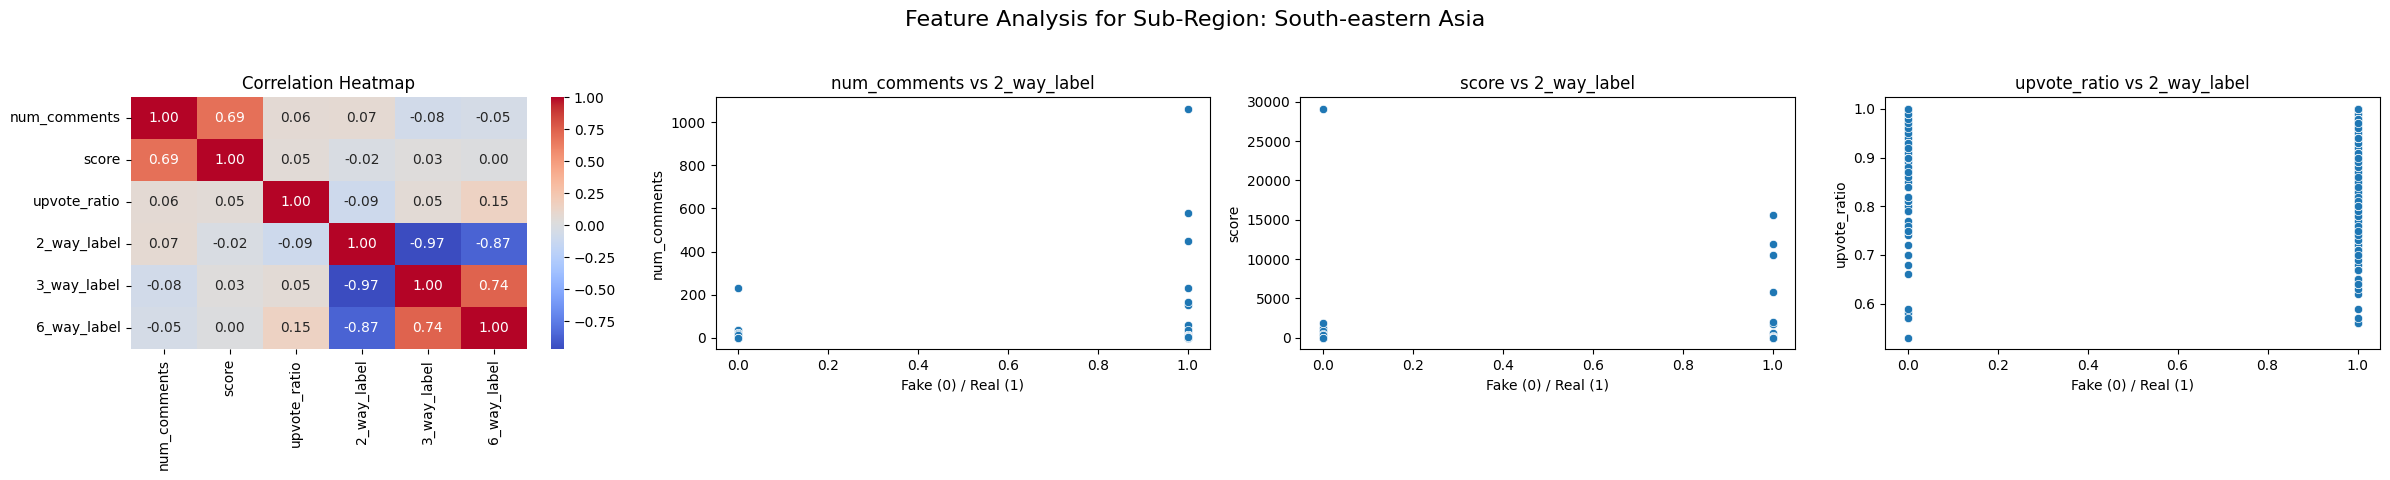


=== Analysis for Sub-Region: Australia and New Zealand ===


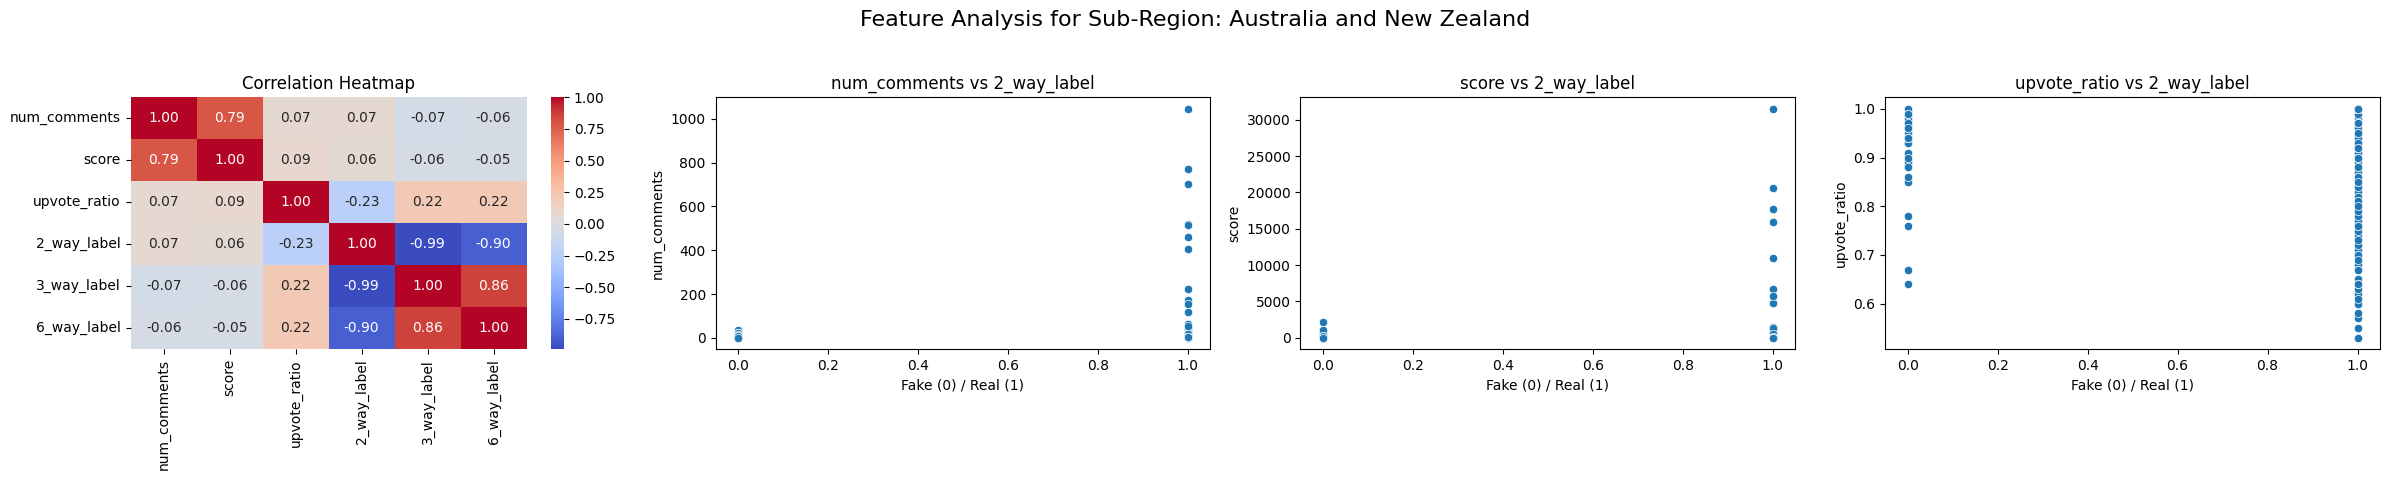


=== Analysis for Sub-Region: Western Asia ===


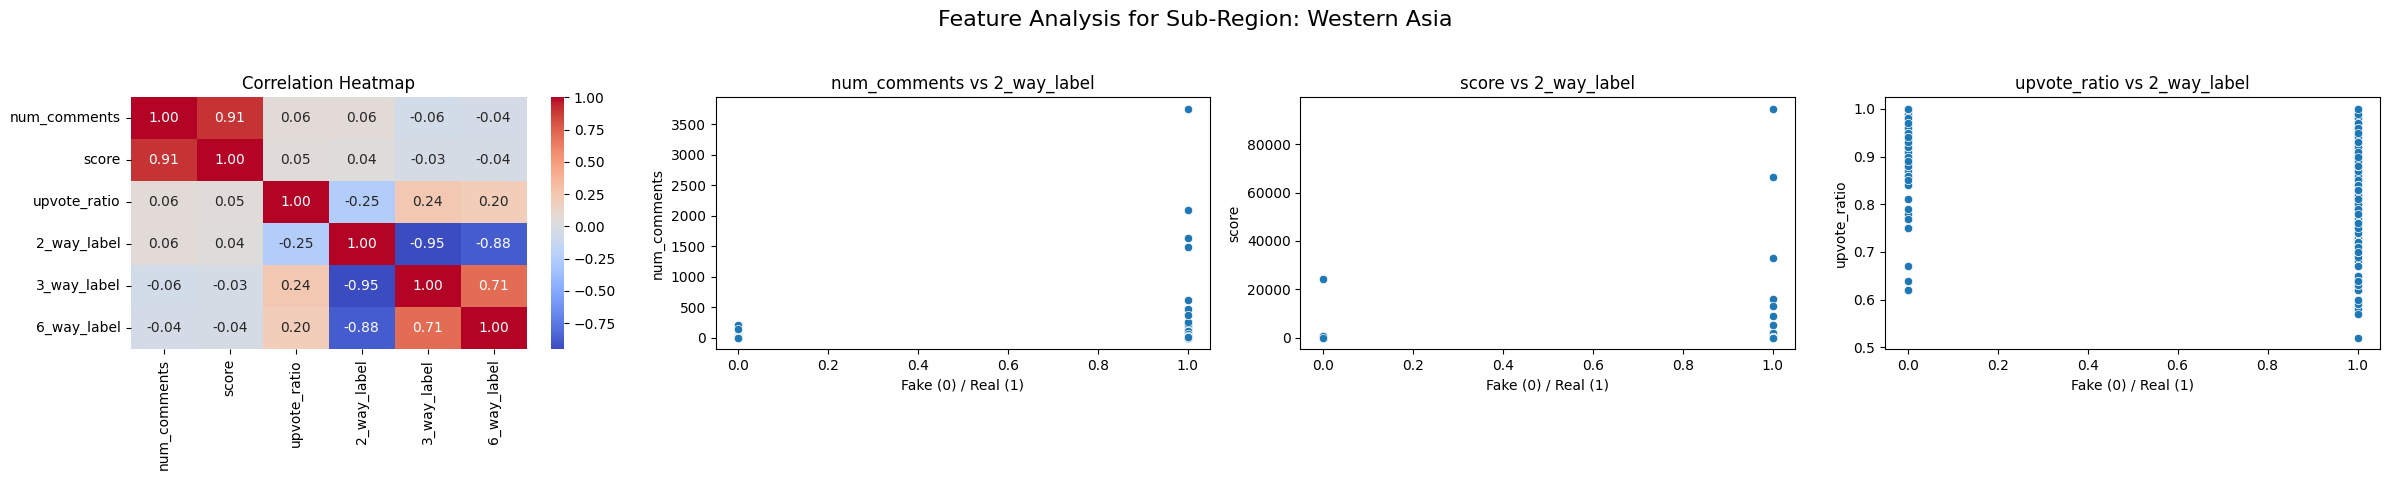


=== Analysis for Sub-Region: Sub-Saharan Africa ===


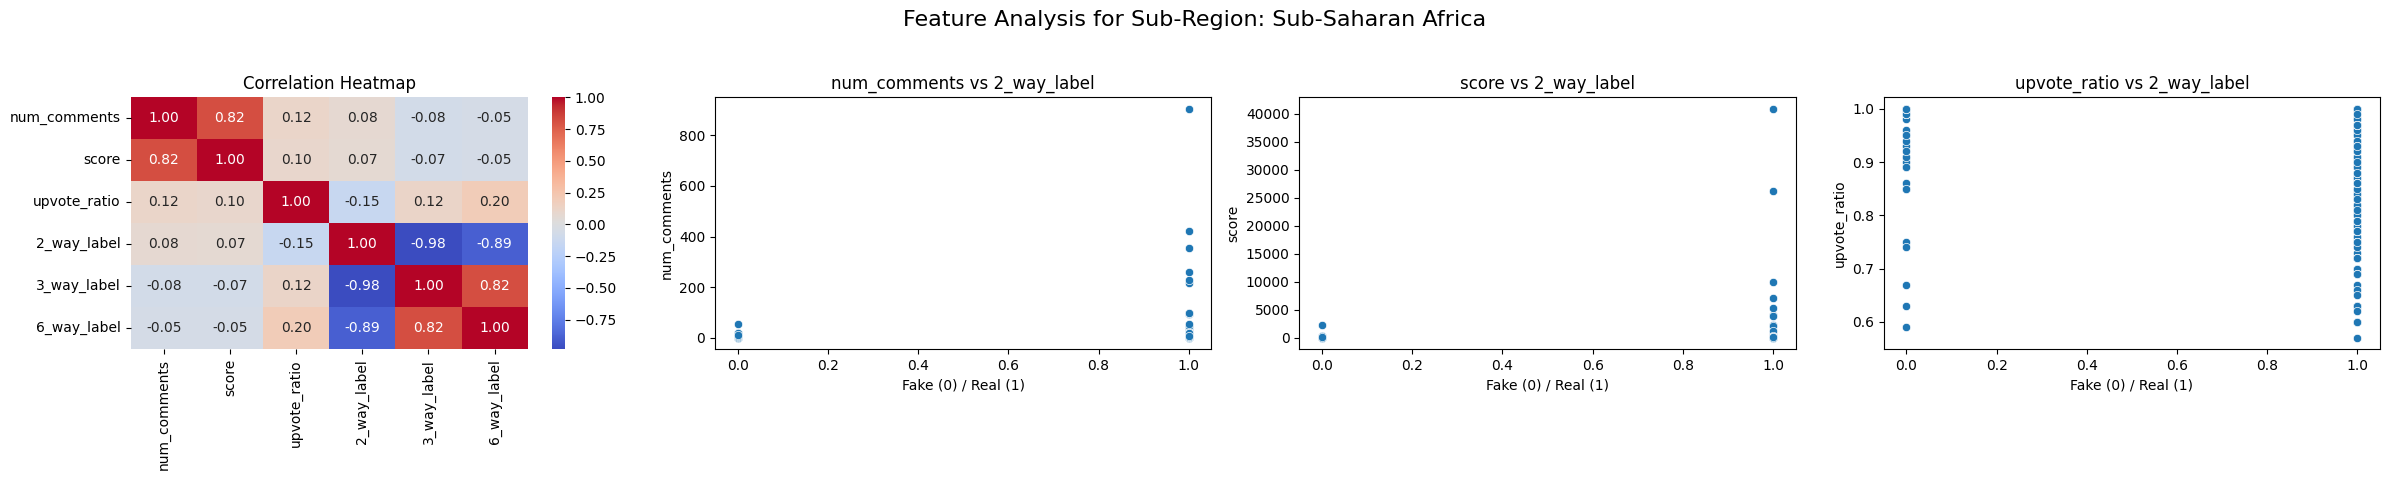


=== Analysis for Sub-Region: Northern Africa ===


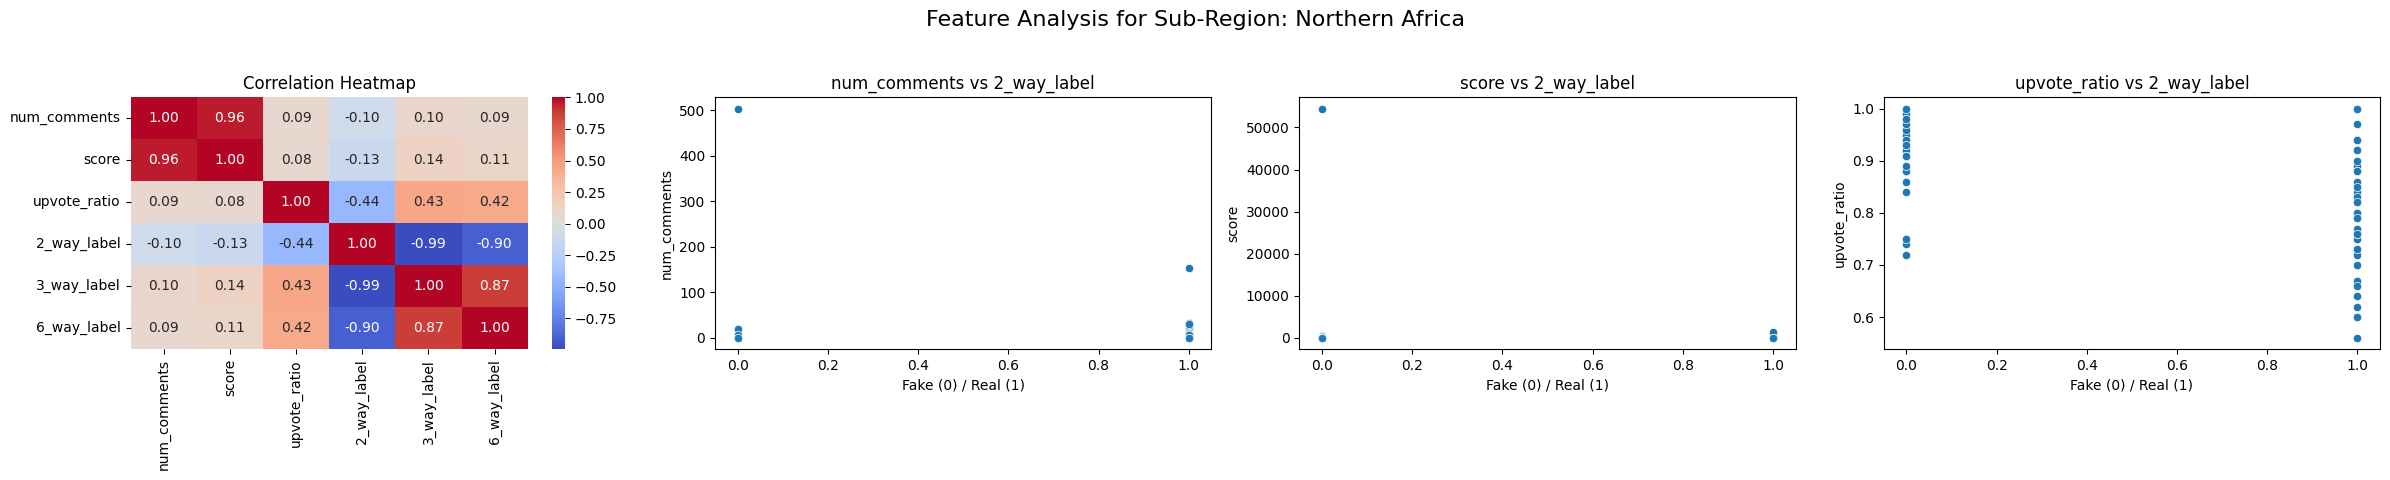


=== Analysis for Sub-Region: Southern Europe ===


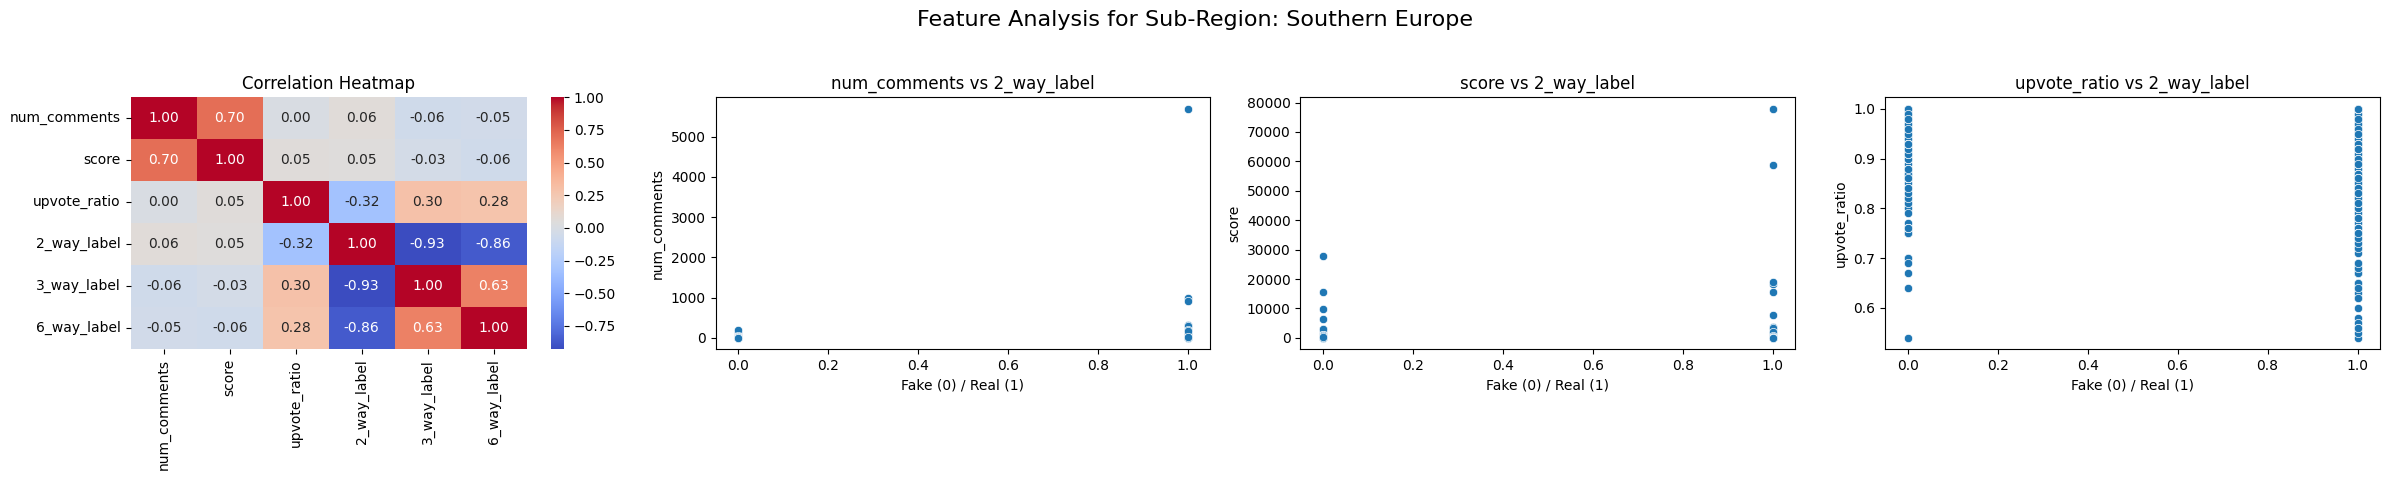


=== Analysis for Sub-Region: Antarctica ===


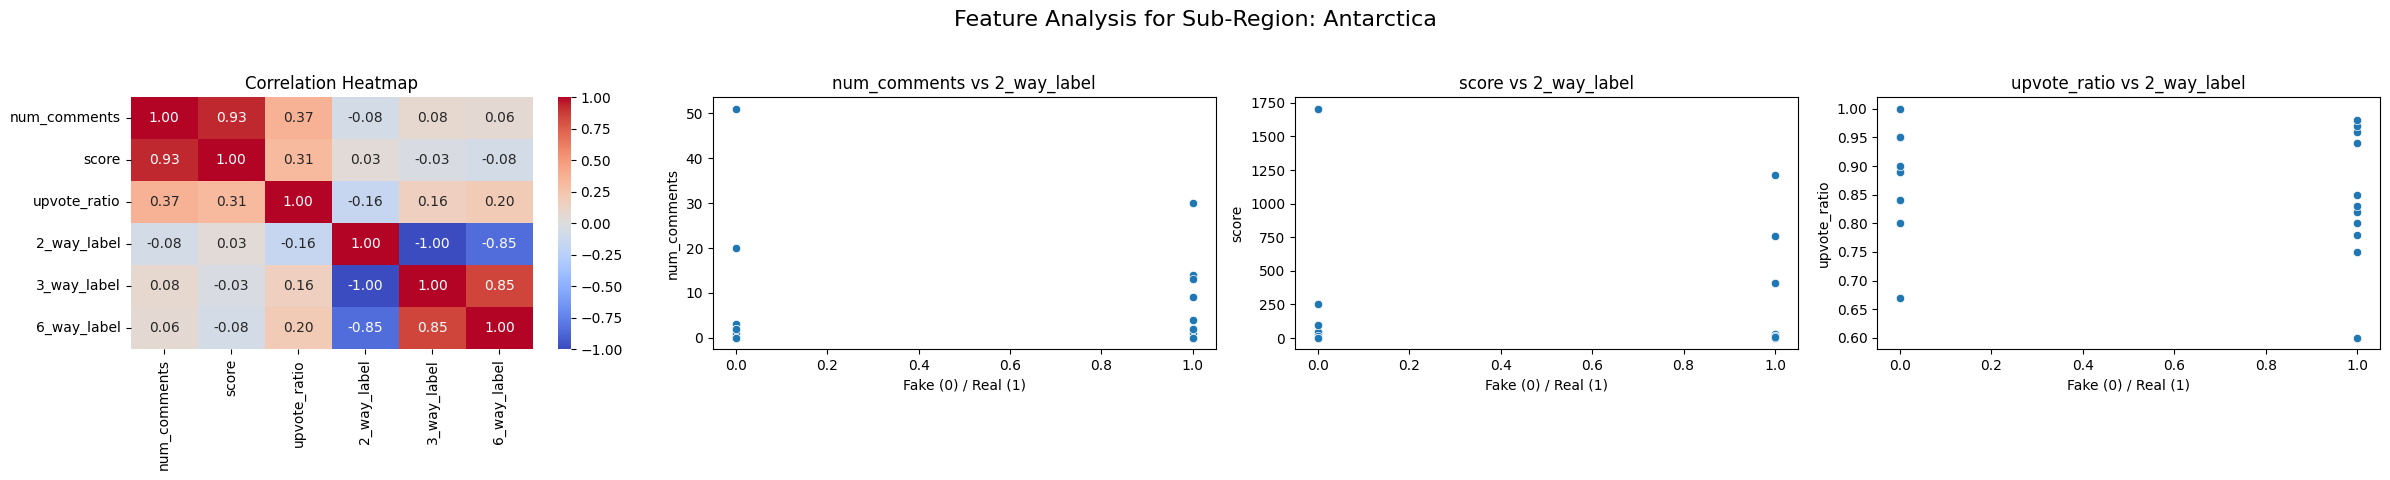


=== Analysis for Sub-Region: Central Asia ===


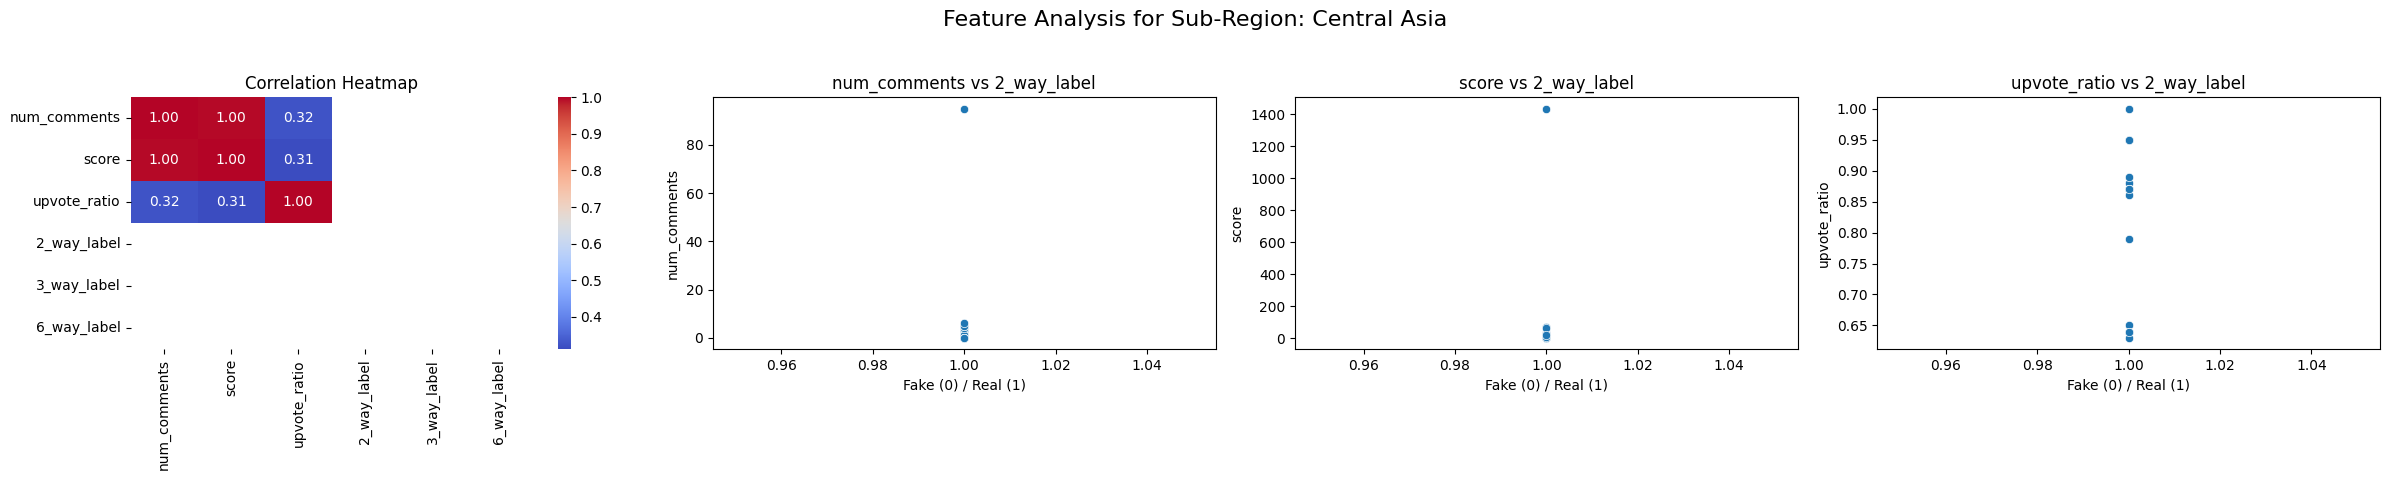

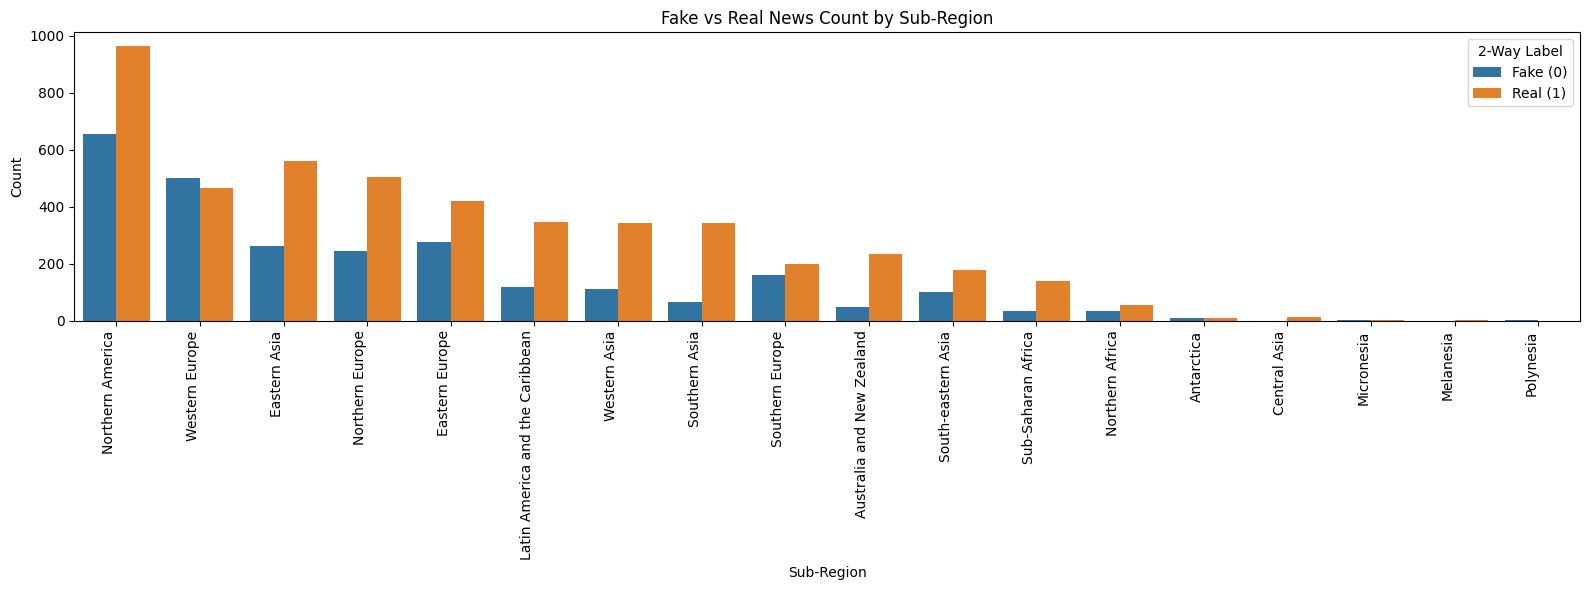

Chi-square test result:
Chi2 = 343.59, p-value = 0.0000, degrees of freedom = 17
→ Significant association between sub-region and news label.


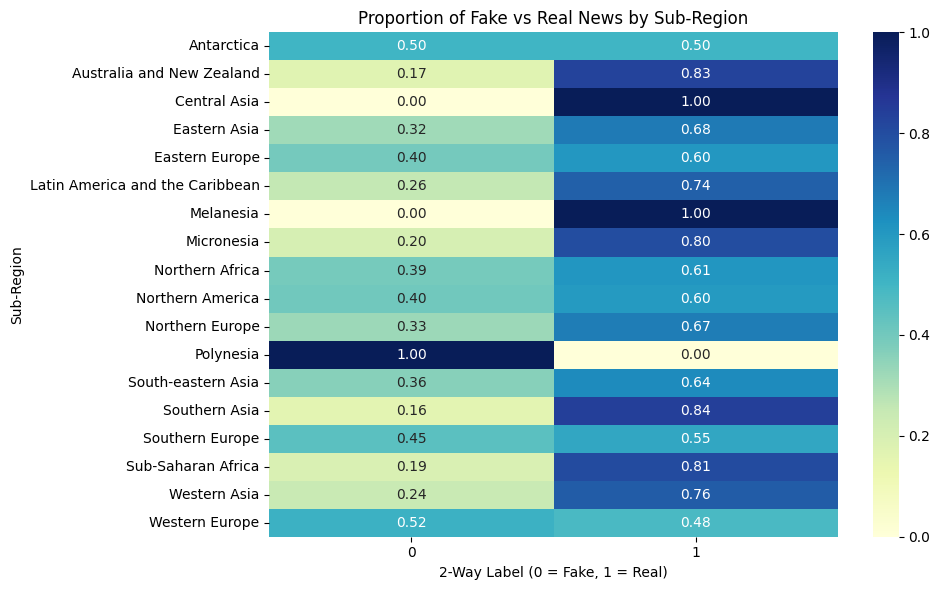

<ipython-input-38-d8178b71aa2f>:139: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=df_filtered, x='sub_region', y='score', hue='2_way_label',


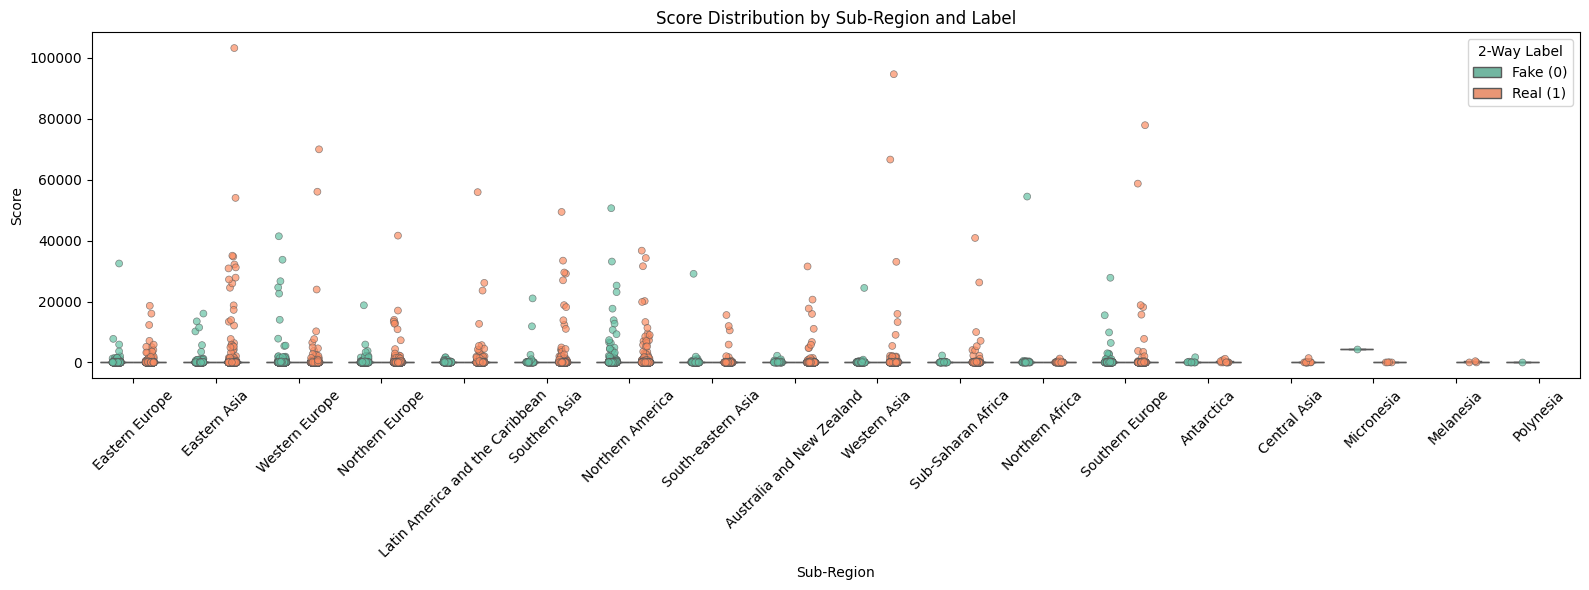


Region: Eastern Europe
  Accuracy : 0.71
  Precision: 0.79
  Recall   : 0.77
  F1 Score : 0.78
  ROC AUC  : 0.75

Region: Eastern Asia
  Accuracy : 0.80
  Precision: 0.82
  Recall   : 0.91
  F1 Score : 0.86
  ROC AUC  : 0.79

Region: Western Europe
  Accuracy : 0.69
  Precision: 0.72
  Recall   : 0.68
  F1 Score : 0.70
  ROC AUC  : 0.76

Region: Northern Europe
  Accuracy : 0.79
  Precision: 0.90
  Recall   : 0.83
  F1 Score : 0.86
  ROC AUC  : 0.80

Region: Latin America and the Caribbean
  Accuracy : 0.69
  Precision: 0.73
  Recall   : 0.88
  F1 Score : 0.80
  ROC AUC  : 0.71

Region: Southern Asia
  Accuracy : 0.85
  Precision: 0.87
  Recall   : 0.97
  F1 Score : 0.92
  ROC AUC  : 0.69

Region: Northern America
  Accuracy : 0.70
  Precision: 0.74
  Recall   : 0.76
  F1 Score : 0.75
  ROC AUC  : 0.77

Region: South-eastern Asia
  Accuracy : 0.66
  Precision: 0.76
  Recall   : 0.74
  F1 Score : 0.75
  ROC AUC  : 0.64

Region: Australia and New Zealand
  Accuracy : 0.88
  Precision: 0

In [38]:
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Load main dataset
df = pd.read_csv('all_validate.csv')

# Load demonyms dataset
demonyms_df = pd.read_csv('demonyms.csv', header=None, names=['demonym', 'country'])
demonym_map = dict(zip(demonyms_df['demonym'].str.lower(), demonyms_df['country']))

# Load continents-map dataset
continent_df = pd.read_csv('continents-map.csv', encoding='ISO-8859-1')
continent_map = dict(zip(continent_df['name'], continent_df['sub-region']))

# Function to extract location and map to subregion using spaCy NER
def get_subregion_from_title_spacy(title):
    title = str(title)
    doc = nlp(title)

    # Extract entities labeled as GPE or LOC
    places = [ent.text for ent in doc.ents if ent.label_ in ('GPE', 'LOC')]

    for place in places:
        country = demonym_map.get(place.lower())
        if not country:
            country = place
        subregion = continent_map.get(country)
        if subregion:
            return subregion

    # Fallback: check each word against demonym_map
    for word in title.lower().split():
        country = demonym_map.get(word)
        if country:
            subregion = continent_map.get(country)
            if subregion:
                return subregion

    return None

# Apply function
df['sub_region'] = df['title'].apply(get_subregion_from_title_spacy)

# Save to new CSV
df.to_csv('all_validate_with_subregion.csv', index=False)

# Filter entries with identified sub-regions
valid_subregion_df = df[df['sub_region'].notna() & (df['sub_region'] != '')]
print(f"Number of entries with identified sub-regions: {len(valid_subregion_df)}")

print(valid_subregion_df.sample(10)[['title', 'sub_region']])

# Continue with analysis using only valid entries
df = valid_subregion_df.copy()

# Features for analysis
features = ['num_comments', 'score', 'upvote_ratio', '2_way_label', '3_way_label', '6_way_label']
scatter_features = ['num_comments', 'score', 'upvote_ratio']
subregions = df['sub_region'].unique()

# Generate plots per subregion
for region in subregions:
    df_region = df[df['sub_region'] == region]

    if len(df_region) < 10:
        continue  # Skip small sets

    print(f"\n=== Analysis for Sub-Region: {region} ===")

    fig, axes = plt.subplots(1, 4, figsize=(24, 5))
    corr = df_region[features].corr(numeric_only=True)
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0])
    axes[0].set_title('Correlation Heatmap')

    for i, feature in enumerate(scatter_features):
        sns.scatterplot(data=df_region, x='2_way_label', y=feature, ax=axes[i + 1])
        axes[i + 1].set_title(f'{feature} vs 2_way_label')
        axes[i + 1].set_xlabel('Fake (0) / Real (1)')
        axes[i + 1].set_ylabel(feature)

    fig.suptitle(f'Feature Analysis for Sub-Region: {region}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Countplot for fake vs real per sub-region
subregion_order = df['sub_region'].value_counts().index

plt.figure(figsize=(16, 6))
sns.countplot(data=df, x='sub_region', hue='2_way_label', order=subregion_order)
plt.xticks(rotation=90, ha='right')
plt.title("Fake vs Real News Count by Sub-Region")
plt.xlabel("Sub-Region")
plt.ylabel("Count")
plt.legend(title='2-Way Label', labels=['Fake (0)', 'Real (1)'])
plt.tight_layout()
plt.show()

# Chi-square test for association
contingency_table = pd.crosstab(df['sub_region'], df['2_way_label'])
chi2, p, dof, ex = chi2_contingency(contingency_table)

print("Chi-square test result:")
print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}, degrees of freedom = {dof}")
if p < 0.05:
    print("→ Significant association between sub-region and news label.")
else:
    print("→ No significant association found.")

# Heatmap of proportions
prop_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
plt.figure(figsize=(10, 6))
sns.heatmap(prop_table, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Proportion of Fake vs Real News by Sub-Region')
plt.xlabel('2-Way Label (0 = Fake, 1 = Real)')
plt.ylabel('Sub-Region')
plt.tight_layout()
plt.show()

# Boxplot of 'score' by sub-region and label
df_filtered = df.copy()  # (If you want to filter, do here)

plt.figure(figsize=(16, 6))
sns.boxplot(data=df_filtered, x='sub_region', y='score', hue='2_way_label',
            palette='Set2', showfliers=False)
sns.stripplot(data=df_filtered, x='sub_region', y='score', hue='2_way_label',
              palette='Set2', dodge=True, jitter=True, alpha=0.7, marker='o',
              edgecolor='gray', linewidth=0.5)

plt.title('Score Distribution by Sub-Region and Label')
plt.xlabel('Sub-Region')
plt.ylabel('Score')
plt.xticks(rotation=45)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], ['Fake (0)', 'Real (1)'], title='2-Way Label')
plt.tight_layout()
plt.show()

# Classification per sub-region with RandomForest
all_metrics = []

for region in subregions:
    df_region = df[df['sub_region'] == region]
    if len(df_region) < 50:
        continue

    X = df_region[['num_comments', 'score', 'upvote_ratio']]
    y = df_region['2_way_label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\nRegion: {region}")
    print(f"  Accuracy : {acc:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall   : {recall:.2f}")
    print(f"  F1 Score : {f1:.2f}")
    print(f"  ROC AUC  : {auc:.2f}")

    all_metrics.append([acc, precision, recall, f1, auc])

if all_metrics:
    metrics_df = pd.DataFrame(all_metrics, columns=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'])
    print("\n=== Overall Mean Metrics Across Sub-Regions ===")
    print(metrics_df.mean())
else:
    print("\nNo sub-regions had sufficient data for evaluation.")

# Logistic Regression with OrdinalEncoder for sub_region
num_cols = ['num_comments', 'score', 'upvote_ratio']
cat_cols = ['sub_region']

preprocessor = ColumnTransformer([
    ('num', make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), num_cols),
    ('cat', OrdinalEncoder(), cat_cols)
])

pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=2000))

# Assuming you want to train on the whole filtered df here:
X = df[num_cols + cat_cols]
y = df['2_way_label']
pipeline.fit(X, y)

coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = num_cols + cat_cols

print("\nFeature Weights (Logistic Regression Coefficients):")
for name, coef in zip(feature_names, coefficients):
    print(f"{name}: {coef:.3f}")